<a href="https://www.kaggle.com/code/thirumani/predicting-biggboss-telugu-season-9-winner?scriptVersionId=242833405" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## <p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:120%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Predicting Telugu Bigg Boss (బిగ్ బాస్ తెలుగు) 9 Season Winner</p>

## Dataset https://www.kaggle.com/datasets/thirumani/bigg-boss-india-hindi-telugu-tamil-kannada

In [1]:
from IPython.display import IFrame
import datetime
print("Notebook was last executed on", datetime.date.today().strftime("%Y-%b-%d"), "with Python version")
!python --version

Notebook was last executed on 2025-May-31 with Python version
Python 3.11.11


In [2]:
# Source: Wikipedia
IFrame('https://upload.wikimedia.org/wikipedia/en/5/58/Bigg_Boss_Telugu_8_Logo.png', width=370, height=280)

### ⚒️ Importing Required Python Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns
from babel.numbers import format_currency
from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

### Check and import dataset

In [4]:
! ls -l /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv
bigg_boss = pd.read_csv('/kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv', encoding = "ISO-8859-1")

nRow, nCol = bigg_boss.shape
print(f'\nThere are {nRow} rows and {nCol} columns in the dataset')

-rw-r--r-- 1 nobody nogroup 272911 May 31 04:26 /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv

There are 1205 rows and 40 columns in the dataset


## 🌟 Exploratory Data Analysis (EDA)

In [5]:
bigg_boss.head(10)

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner
0,Hindi,1,Amit Sadh,Soap Actor,Male,Young,3-Nov-06,NaN,10.0,5.0,No,86,15,3-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
1,Hindi,1,Anupama Verma,Model,Female,Young,3-Nov-06,NaN,5.0,8.0,No,86,15,3-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,Middle,3-Nov-06,NaN,4.0,9.0,No,86,15,3-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
3,Hindi,1,Bobby Darling,Activist,Transgender,Young,3-Nov-06,NaN,1.0,12.0,No,86,15,3-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
4,Hindi,1,Carol Gracias,Model,Female,Young,3-Nov-06,26-Jan-07,12.0,2.0,No,86,15,3-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
5,Hindi,1,Deepak Parashar,Actor,Male,Old,3-Nov-06,NaN,2.0,11.0,No,86,15,3-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
6,Hindi,1,Kashmira Shah,Actress,Female,Middle,3-Nov-06,NaN,3.0,10.0,No,86,15,3-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
7,Hindi,1,Ragini Shetty,Commoner,Female,Young,3-Nov-06,NaN,7.0,7.0,No,86,15,3-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
8,Hindi,1,Rahul Roy,Actor,Male,Middle,3-Nov-06,NaN,NaN,1.0,No,86,15,3-Nov-06,26-Jan-07,Arshad Warsi,NaN,"1,00,00,000",Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,4.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
9,Hindi,1,Rakhi Sawant,Actress,Female,Middle,3-Nov-06,NaN,11.0,4.0,No,86,15,3-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,3,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0


In [6]:
bigg_boss.tail(10).T

,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204
Language,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam
Season Number,6,6,6,6,6,6,6,6,6,6
Name,Sreerekha Rajagopal,Sreethu Krishnan,Suresh Menon,Yamuna Rani,Abhishek K Jayadeep,Sibin Benjamin,Nandana C,Abhishek Sreekumar,Pooja Krishna,Sai Krishnan
Profession,Actress,Soap Actress,Actor,Actress,Pageant Winner,Disc Jockey,Commoner - Student,Actor,Social Media Star,Social Media Star
Gender,Female,Female,Male,Female,Transgender,Male,Female,Male,Female,Male
Age,Middle,Young,Old,Old,Young,Middle,Young,Young,Young,Middle
Entry Date,10-Mar-24,10-Mar-24,10-Mar-24,10-Mar-24,NaN,NaN,NaN,NaN,NaN,NaN
Elimination Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Elimination Week Number,9.0,13.0,2.0,4.0,7.0,7.0,12.0,14.0,7.0,13.0
Contestant Number,10.0,7.0,16.0,3.0,20.0,21.0,22.0,23.0,24.0,25.0


In [7]:
bigg_boss.sample(10)

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner
281,Hindi,15,Akasa Singh,Singer,Female,Young,2-Oct-21,NaN,4.0,9.0,No,120,24,2-Oct-21,30-Jan-22,Salman Khan,NaN,0,Colors,Voot,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Sankat in Jungle,Jungle,3,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
249,Hindi,14,Nikki Tamboli,Actress,Female,Young,3-Oct-20,NaN,20.0,2.0,No,141,22,3-Oct-20,21-Feb-21,Salman Khan,NaN,0,Colors,Voot,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Ab Scene Paltega,Futuristic,11,0.0,1.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,7.0,1.0,0
444,Kannada,3,Sushma Veer,Theatre Artist,Female,Middle,NaN,NaN,11.0,18.0,Yes,98,18,25-Oct-15,31-Jan-16,Sudeep,NaN,0,Colors Kannada,NaN,NaN,Karnataka,Bengaluru,No,There is no place for drama here,NaN,2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
1178,Malayalam,5,Omar Lulu,Film Director,Male,Middle,NaN,NaN,6.0,20.0,Yes,99,21,26-Mar-23,2-Jul-23,Mohanlal,NaN,0,Asianet,Disney+ Hotstar,NaN,Kerala,Mumbai,No,Battle of the Originals - The Fire Explodes!,NaN,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,0.0,0
1071,Bengali,2,Mikhail Bora,Commoner,Male,Middle,4-Apr-16,NaN,NaN,2.0,No,102,16,4-Apr-16,15-Jul-16,Jeet,NaN,0,Colors Bangla,NaN,6.50,West Bengal,Lonavala,No,NaN,NaN,3,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
1050,Bengali,1,Abhijeet Burman,Actor,Male,Old,17-Jun-13,NaN,12.0,9.0,No,90,15,17-Jun-13,14-Sep-13,Mithun Chakraborthy,NaN,0,ETV Bangla,NaN,2.90,West Bengal,Lonavala,No,NaN,NaN,5,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
26,Hindi,2,Sambhavna Seth,Actress,Female,Young,17-Aug-08,NaN,7.0,3.0,No,98,15,17-Aug-08,22-Nov-08,Shilpa Shetty,NaN,0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
522,Kannada,7,Raksha Somashekhar,Actress,Female,Young,NaN,NaN,8.0,20.0,Yes,112,20,13-Oct-19,2-Feb-20,Sudeep,NaN,0,Colors Kannada,Voot,NaN,Karnataka,Bengaluru,No,NaN,NaN,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
825,Tamil,3,Fathima Babu,News Presenter,Female,Old,23-Jun-19,NaN,2.0,1.0,No,105,17,23-Jun-19,6-Oct-19,Kamal Haasan,NaN,0,Star Vijay,Disney+ Hotstar,8.80,Tamil Nadu,Chennai,No,This is not just a show... Our life.,Chettinad Museum,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
648,Telugu,2,Tanish Alladi,Actor,Male,Young,10-Jun-18,30-Sep-18,16.0,4.0,No,112,18,10-Jun-18,30-Sep-18,Nani,NaN,0,Star Maa,NaN,15.00,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,5,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,1.0,0


In [8]:
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 40 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Language                            1205 non-null   object 
 1   Season Number                       1205 non-null   object 
 2   Name                                1205 non-null   object 
 3   Profession                          1205 non-null   object 
 4   Gender                              1205 non-null   object 
 5   Age                                 1205 non-null   object 
 6   Entry Date                          1033 non-null   object 
 7   Elimination Date                    223 non-null    object 
 8   Elimination Week Number             1063 non-null   float64
 9   Contestant Number                   1126 non-null   float64
 10  Wild Card                           1205 non-null   object 
 11  Season Length                       1205 no

In [9]:
bigg_boss.describe().T.round(2).style.background_gradient(cmap = 'Blues')

,count,mean,std,min,25%,50%,75%,max
Elimination Week Number,1063.000000,9.070000,4.820000,1.000000,5.000000,9.000000,14.000000,20.000000
Contestant Number,1126.000000,10.070000,5.720000,1.000000,5.000000,10.000000,15.000000,25.000000
Season Length,1205.000000,99.060000,19.100000,28.000000,98.000000,105.000000,105.000000,141.000000
Number of Housemates,1205.000000,18.940000,2.660000,10.000000,17.000000,19.000000,21.000000,25.000000
Average TRP,679.000000,9.490000,5.490000,2.720000,4.400000,8.400000,15.000000,20.100000
Number of Evictions Faced,1205.000000,4.470000,3.080000,0.000000,2.000000,4.000000,7.000000,14.000000
Number of Times Elected as Captain,1040.000000,0.620000,0.770000,0.000000,0.000000,0.000000,1.000000,5.000000
Number of Re-entries,1011.000000,0.110000,0.340000,0.000000,0.000000,0.000000,0.000000,3.000000
Walked,1011.000000,0.100000,0.310000,0.000000,0.000000,0.000000,0.000000,2.000000
Ejected,1005.000000,0.040000,0.210000,0.000000,0.000000,0.000000,0.000000,1.000000


In [10]:
bigg_boss['Season Start Date'] = pd.to_datetime(bigg_boss['Season Start Date'])
bigg_boss['Season End Date'] = pd.to_datetime(bigg_boss['Season End Date'])
bigg_boss['Entry Date'] = pd.to_datetime(bigg_boss['Entry Date'])
bigg_boss['Elimination Date'] = pd.to_datetime(bigg_boss['Elimination Date'])

In [11]:
bigg_boss['Finalist'] = bigg_boss['Finalist'].astype(pd.Int32Dtype())
bigg_boss['Elimination Week Number'] = bigg_boss['Elimination Week Number'].astype(pd.Int32Dtype())
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].astype(pd.Int32Dtype())
bigg_boss['Number of Re-entries'] = bigg_boss['Number of Re-entries'].astype(pd.Int32Dtype())
bigg_boss['Number of Times Elected as Captain'] = bigg_boss['Number of Times Elected as Captain'].astype(pd.Int32Dtype())
bigg_boss['Social Media Popularity'] = bigg_boss['Social Media Popularity'].astype(pd.Int32Dtype())

bigg_boss['Prize Money (INR)'] = bigg_boss['Prize Money (INR)'].str.replace(',','')
bigg_boss['Prize Money (INR)'] = pd.to_numeric(bigg_boss['Prize Money (INR)'])

bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 40 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Language                            1205 non-null   object        
 1   Season Number                       1205 non-null   object        
 2   Name                                1205 non-null   object        
 3   Profession                          1205 non-null   object        
 4   Gender                              1205 non-null   object        
 5   Age                                 1205 non-null   object        
 6   Entry Date                          1033 non-null   datetime64[ns]
 7   Elimination Date                    223 non-null    datetime64[ns]
 8   Elimination Week Number             1063 non-null   Int32         
 9   Contestant Number                   1126 non-null   float64       
 10  Wild Card               

In [12]:
# Unique values in each column
for col in bigg_boss.columns:
    print("Number of unique values in", col, "-", bigg_boss[col].nunique())

Number of unique values in Language - 7
Number of unique values in Season Number - 25
Number of unique values in Name - 1131
Number of unique values in Profession - 88
Number of unique values in Gender - 4
Number of unique values in Age - 3
Number of unique values in Entry Date - 73
Number of unique values in Elimination Date - 141
Number of unique values in Elimination Week Number - 20
Number of unique values in Contestant Number - 25
Number of unique values in Wild Card - 2
Number of unique values in Season Length - 25
Number of unique values in Number of Housemates - 13
Number of unique values in Season Start Date - 64
Number of unique values in Season End Date - 61
Number of unique values in Host Name - 18
Number of unique values in Guest Host Name - 7
Number of unique values in Prize Money (INR) - 22
Number of unique values in Broadcasted By - 12
Number of unique values in OTT Platform - 3
Number of unique values in Average TRP - 35
Number of unique values in Most Viewed States - 

In [13]:
# Number of seasons in all Indian languages
print("Total", bigg_boss.groupby('Language')['Season Number'].nunique().sum(), "#BiggBoss seasons broadcasted (in TV & OTT)")
print(bigg_boss['Winner'].sum().astype(int) + 2, "seasons completed")
print(bigg_boss.loc[bigg_boss['Winner'].isnull(), :].groupby('Language')['Season Number'].nunique().sum(), "season(s) running")

# For Bigg Boss Hindi season 8 & Malayalam season 2 winners were not declared

Total 65 #BiggBoss seasons broadcasted (in TV & OTT)
65 seasons completed
0 season(s) running


In [14]:
# Seasons broadcasted ONLY in OTT platforms, eventually in TV
print(bigg_boss.loc[bigg_boss['OTT Season']=='Yes'].groupby('Language')['Season Number'].nunique().sum(), "seasons broadcasted ONLY in OTT platforms (eventually in Television)")

6 seasons broadcasted ONLY in OTT platforms (eventually in Television)


## 📊 Bigg Boss Hindi has many seasons compared to other Indian languages. So, the number of housemates are more in Hindi.

In [15]:
# Number of seasons in each Indian language
print(bigg_boss.groupby('Language')['Season Number'].nunique().nlargest(10))

Language
Hindi        22
Kannada      12
Tamil         9
Telugu        9
Malayalam     6
Marathi       5
Bengali       2
Name: Season Number, dtype: int64


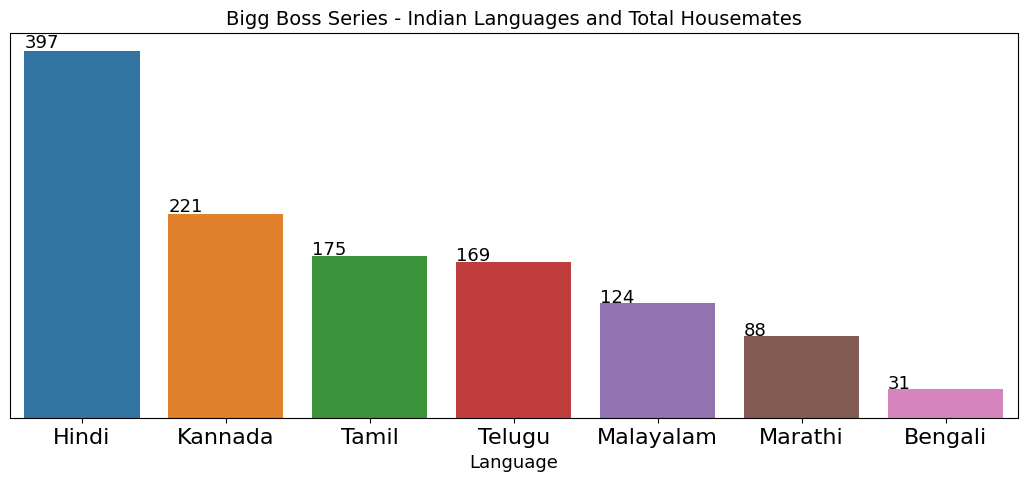

In [16]:
# Total number of Bigg Boss housemates, language wise
fig = plt.figure(figsize=(13, 5))
ax = sns.countplot(x='Language', data=bigg_boss, order=bigg_boss['Language'].value_counts().index)
ax.set_title('Bigg Boss Series - Indian Languages and Total Housemates', fontsize=14)
plt.xticks(fontsize=16)
plt.yticks([])
plt.xlabel("Language", fontsize=13)
plt.ylabel("")
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01), size=13)

## 🇮🇳 In Bigg Boss India seasons, most of the housemates entered in first day/week

Wild Card
No     1017
Yes     188
Name: count, dtype: int64 

Wild Card
No     84%
Yes    16%
Name: proportion, dtype: object 



<Axes: ylabel='count'>

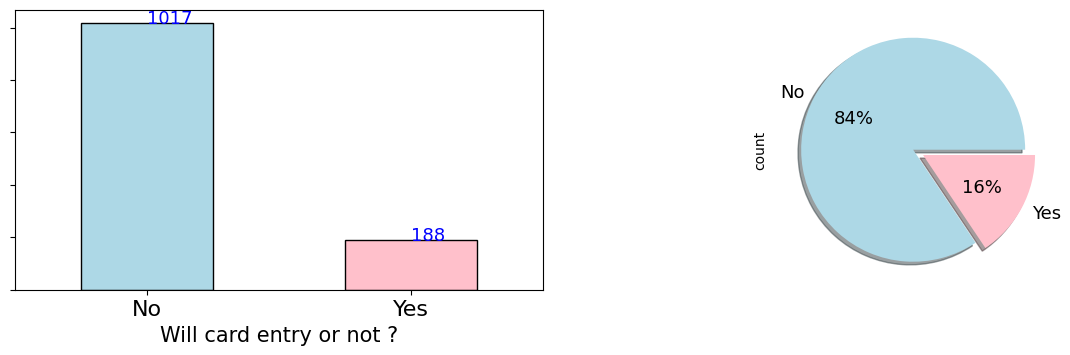

In [17]:
# Number of normal entries and wild card entries
print(bigg_boss['Wild Card'].value_counts(), "\n")
print(round(bigg_boss['Wild Card'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%', regex=False), "\n")

plt.figure(figsize=(15, 8))
ax1=plt.subplot(221)
bigg_boss['Wild Card'].value_counts().plot(kind='bar', color=["lightblue","pink"], ec="k")
plt.xlabel("Will card entry or not ?", fontsize=15)
plt.xticks(rotation=0, fontsize=16)
plt.setp(ax1.get_yticklabels(), visible=False)

for x,y in enumerate(bigg_boss['Wild Card'].value_counts()):
    plt.annotate(y, (x,y), fontsize=13, color="blue")

ax2=plt.subplot(222)
bigg_boss['Wild Card'].value_counts().plot(kind='pie', autopct='%.0f%%', explode=(0,0.10), colors=["lightblue","pink"], shadow=True, fontsize=13)

Age
Middle    620
Young     508
Old        77
Name: count, dtype: int64 

Age
Middle    51%
Young     42%
Old        6%
Name: proportion, dtype: object


<Axes: ylabel='count'>

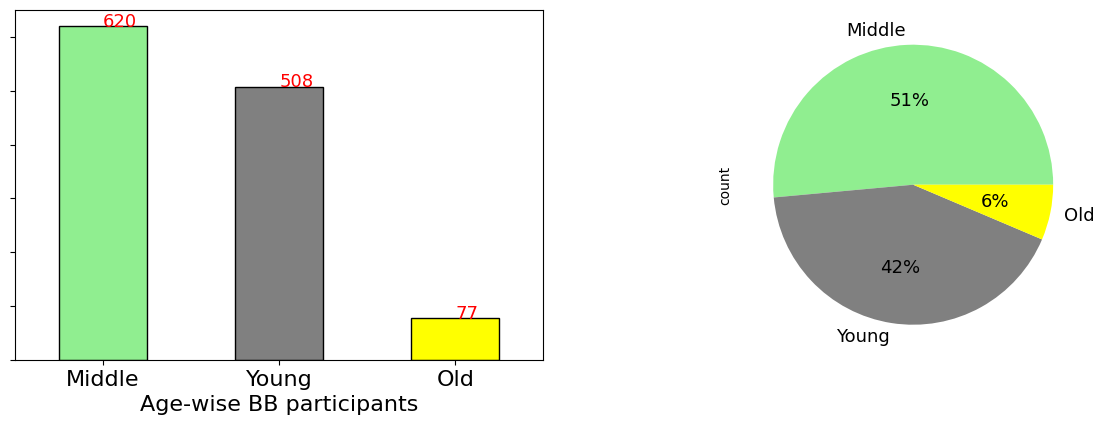

In [18]:
# Age of housemates   (Age <30 young, 30-50 middle, >50 old)
print(bigg_boss['Age'].value_counts(), '\n')

# In percentage
print(round(bigg_boss['Age'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

plt.figure(figsize=(15, 10))
ax1=plt.subplot(221)
bigg_boss['Age'].value_counts().plot(kind='bar', color=["lightgreen", "gray", "yellow"], ec="k")
plt.xlabel("Age-wise BB participants", fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.setp(ax1.get_yticklabels(), visible=False)

for x,y in enumerate(bigg_boss['Age'].value_counts()):
    plt.annotate(y, (x,y), fontsize=13, color="Red")

ax2=plt.subplot(222)
bigg_boss['Age'].value_counts().plot(kind='pie', autopct='%.0f%%', explode = (0, 0, 0), colors=["lightgreen", "gray", "yellow"], fontsize=13)

In [19]:
# Common people has many professions, so clubbing them into one category
bigg_boss['Profession'] = bigg_boss['Profession'].fillna('UNKNOWN')
bigg_boss.loc[bigg_boss['Profession'].str.contains('Commoner'),'Profession'] = 'Commoner'

## 💚 Number of film actresses entered into the Bigg Boss houses, are more when compared to other professions

Profession
Actress         231
Actor           152
Soap Actress    134
Soap Actor       81
Model            78
               ... 
Boxer             1
Pharmacist        1
Writer            1
Cartoonist        1
Disc Jockey       1
Name: count, Length: 63, dtype: int64


Text(0, 0.5, 'Count')

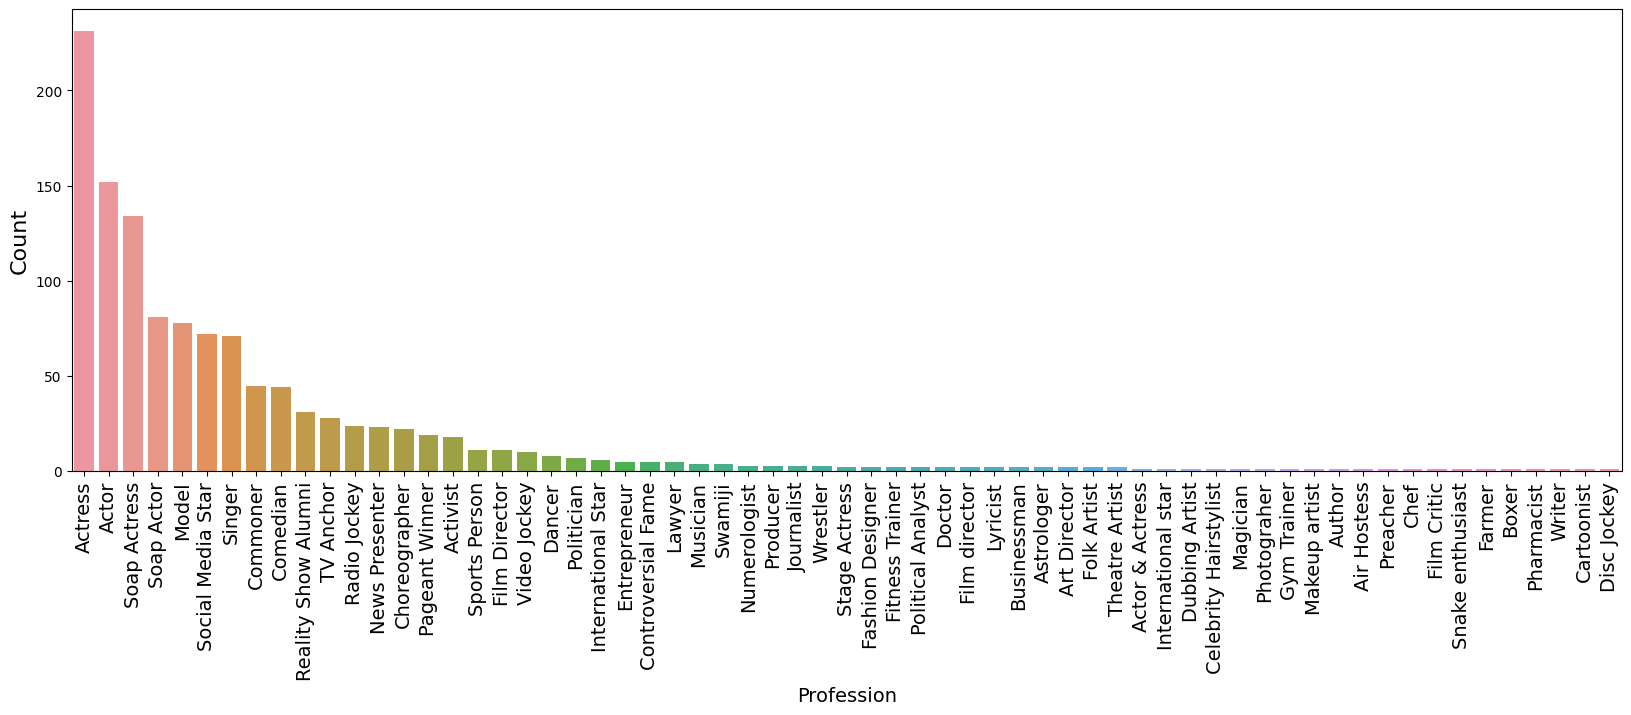

In [20]:
# Participant's Profession
print(bigg_boss['Profession'].value_counts())
fig = plt.figure(figsize=(20, 6))
sns.countplot(x='Profession', data=bigg_boss, order=bigg_boss['Profession'].value_counts().index)
plt.xticks(fontsize=14, rotation=90)
plt.xlabel("Profession", fontsize=14)
plt.ylabel("Count", fontsize=16)

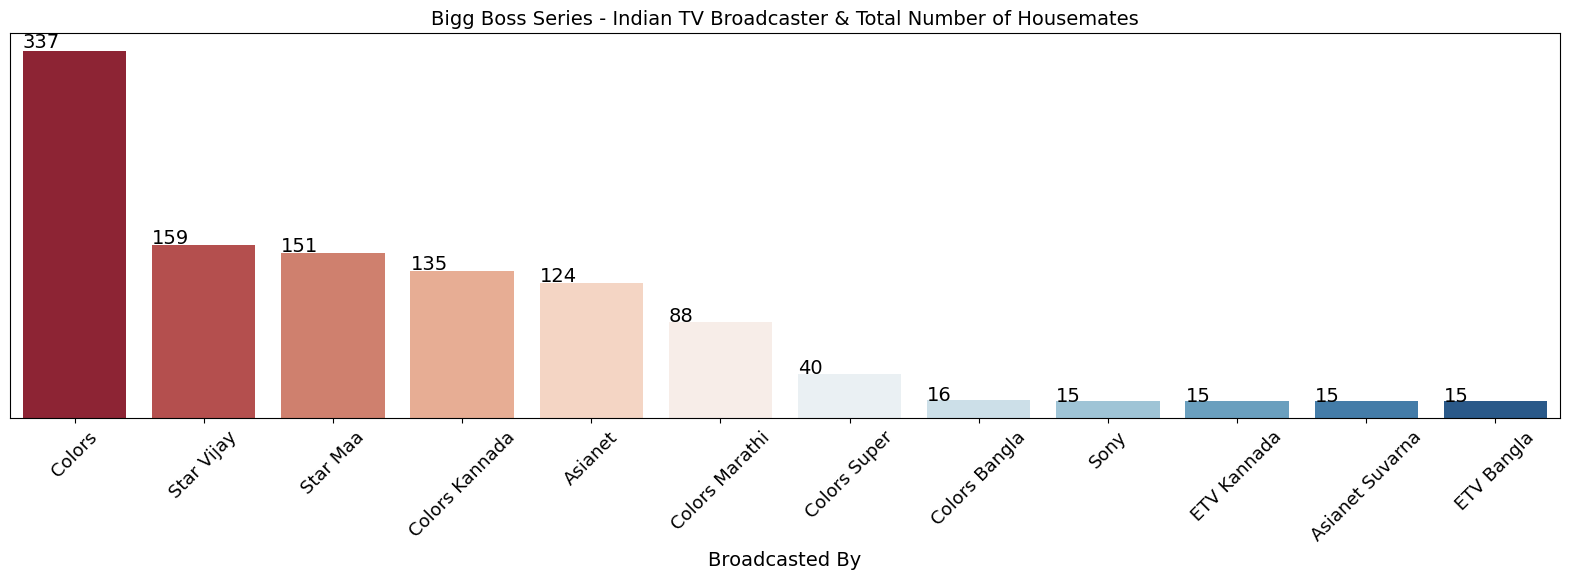

In [21]:
# TV Broadcaster
fig = plt.figure(figsize=(20, 5))
ax = sns.countplot(x='Broadcasted By', data=bigg_boss, palette='RdBu', order=bigg_boss['Broadcasted By'].value_counts().index)
ax.set_title('Bigg Boss Series - Indian TV Broadcaster & Total Number of Housemates', fontsize=14)
plt.xticks(fontsize=13, rotation=45)
plt.yticks([])
plt.xlabel("Broadcasted By", fontsize=14)
plt.ylabel("")
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01), size=14)

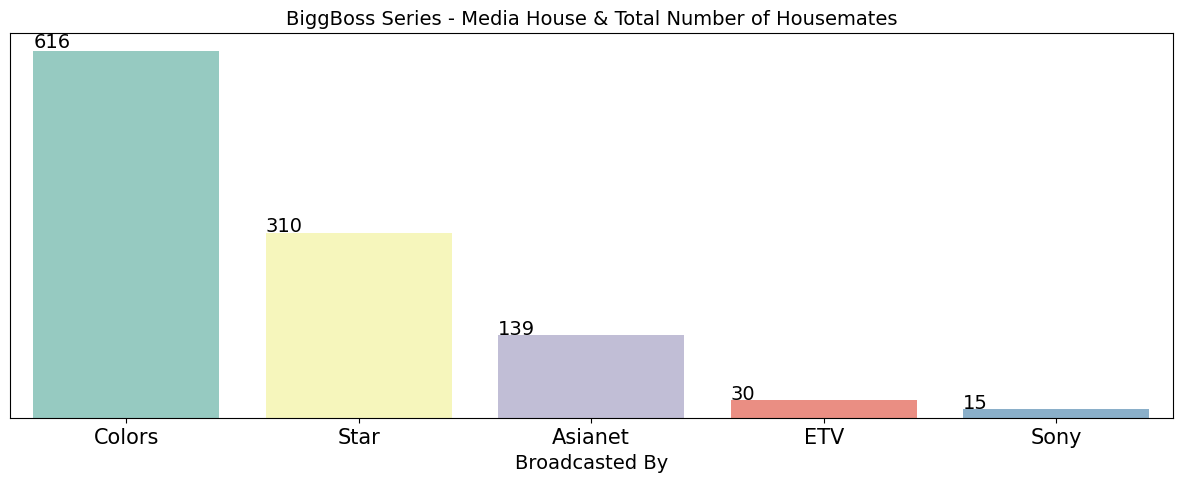

In [22]:
# Media House
fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(x=bigg_boss['Broadcasted By'].str.split().str.get(0).replace('Disney+', 'Star'), data=bigg_boss, palette='Set3', order=bigg_boss['Broadcasted By'].str.split().str.get(0).replace('Disney+', 'Star').value_counts().index)
ax.set_title('BiggBoss Series - Media House & Total Number of Housemates', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks([])
plt.xlabel("Broadcasted By", fontsize=14)
plt.ylabel("")
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01), size=14)

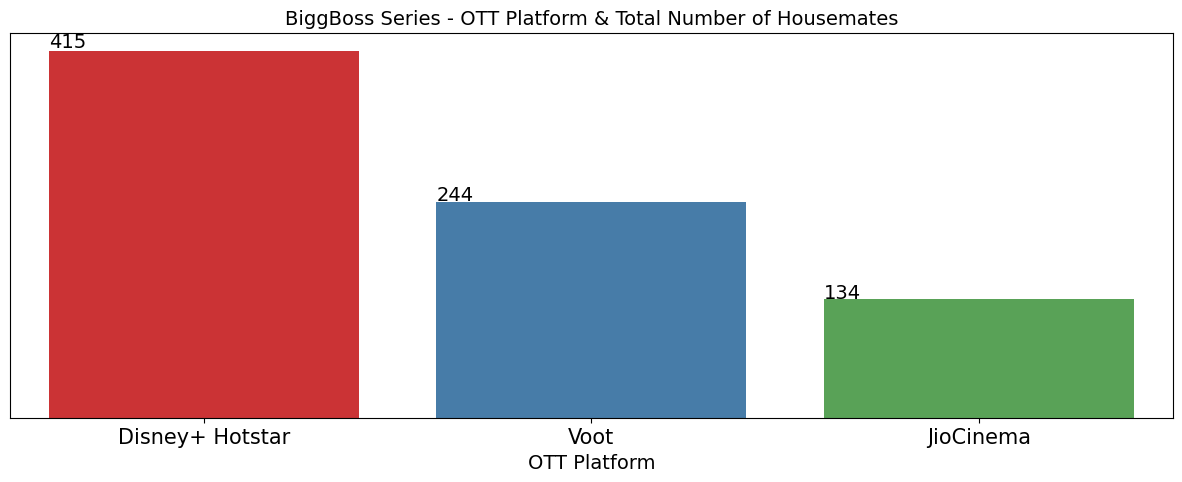

In [23]:
# OTT platforms
fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(x=bigg_boss['OTT Platform'], data=bigg_boss, palette='Set1', order=bigg_boss['OTT Platform'].value_counts().index)
ax.set_title('BiggBoss Series - OTT Platform & Total Number of Housemates', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks([])
plt.xlabel("OTT Platform", fontsize=14)
plt.ylabel("")
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01), size=14)

## 💢 Salman Khan hosted most number of seasons (in Bigg Boss Hindi), Sudeep is next on the list

In [24]:
# Bigg Boss main hosts and number of seasons they hosted
bigg_boss.groupby('Host Name')['Season Number'].nunique().nlargest(25)

Host Name
Salman Khan            16
Sudeep                 12
Kamal Haasan            8
Nagarjuna               7
Mohanlal                6
Mahesh Manjrekar        4
Amitabh Bachchan        1
Shilpa Shetty           1
Riteish Deshmukh        1
Nani                    1
Mithun Chakraborthy     1
Anil Kapoor             1
Karan Johar             1
Jr. NTR                 1
Jeet                    1
Farah Khan              1
Arshad Warsi            1
Vijay Sethupathi        1
Name: Season Number, dtype: int64

In [25]:
# Temporary or Guest host who hosted the week-end episodes
bigg_boss.groupby('Guest Host Name')['Season Number'].nunique().nlargest(10)

Guest Host Name
Ramya Krishnan       2
Farah Khan           1
Karan Johar          1
Samantha             1
Sanjay Dutt          1
Siddhartha Jadhav    1
Simbu                1
Name: Season Number, dtype: int64

## 👩 In all Bigg Boss competitions, in languages and in all seasons, Female contestants are more

Gender
Female         621
Male           571
Transgender     11
Pair             2
Name: count, dtype: int64 

Gender
Female         52%
Male           47%
Transgender     1%
Pair            0%
Name: proportion, dtype: object 



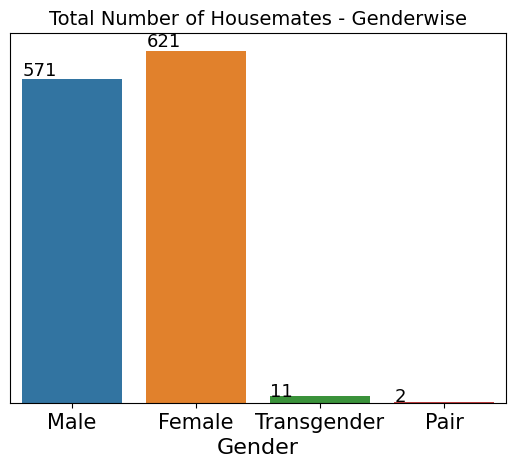

In [26]:
# Housemate's Gender
print(bigg_boss['Gender'].value_counts(), "\n")

# In percentage
print(round(bigg_boss['Gender'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'), "\n")

ax = sns.countplot(data = bigg_boss, x = 'Gender')
ax.set_title('Total Number of Housemates - Genderwise', fontsize=14)
plt.xticks(fontsize=15)
plt.yticks([])
plt.xlabel("Gender", fontsize=16)
plt.ylabel("")
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01), size=13)

### 11 Transgenders (LGBTQIA+) participated in all Indian languages

In [27]:
# Maximum TRP of Bigg Boss India seasons (Big Brother in India)
print("Maximum TRP", bigg_boss['Average TRP'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Average TRP']==bigg_boss['Average TRP'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum TRP 20.1 

Language Season Number
  Telugu             4


In [28]:
# Smallest season of Indian Bigg Boss seasons
print("Smallest season", bigg_boss['Season Length'].min(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].min()][["Language","Season Number"]].head(1).to_string(index=False))

Smallest season 28 days 

Language Season Number
   Hindi     Halla Bol


In [29]:
# Longest season of Bigg Boss Indian seasons
print("Longest season", bigg_boss['Season Length'].max(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Longest season 141 days 

Language Season Number
   Hindi            14


## 🎆 Shark Tank India data set https://www.kaggle.com/datasets/thirumani/shark-tank-india

In [30]:
print("Maximum number of contestants in one season:", bigg_boss['Number of Housemates'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of Housemates']==bigg_boss['Number of Housemates'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum number of contestants in one season: 25 

 Language Season Number
Malayalam             6


In [31]:
print("Maximum number of evictions faced in one season:", bigg_boss['Number of Evictions Faced'].max(), "\n")
print("\nTop 6 contestants who faced highest/maximum number of evictions\n")
print(bigg_boss.loc[bigg_boss['Number of Evictions Faced']>=bigg_boss['Number of Evictions Faced'].max()-1][["Language","Season Number","Name","Number of Evictions Faced"]].head(10).sort_values("Number of Evictions Faced",ascending=False).to_string(index=False))

Maximum number of evictions faced in one season: 14 


Top 6 contestants who faced highest/maximum number of evictions

Language Season Number               Name  Number of Evictions Faced
   Hindi            14      Rubina Dilaik                         14
 Kannada             8 Prashanth Sambargi                         14
 Kannada            11      Mokshitha Pai                         14
   Tamil             8    Jacquline Lydia                         14
   Hindi            13         Arti Singh                         13
 Kannada             7      Chandan Achar                         13
 Kannada            11       Bhavya Gowda                         13
  Telugu             7       Prince Yawar                         13
   Tamil             6     Mohammed Azeem                         13


In [32]:
bigg_boss['Season Length in weeks'] = round(bigg_boss['Season Length']/7,0).astype(pd.Int32Dtype())
bigg_boss['Evictions Faced Percentage'] = round(bigg_boss['Number of Evictions Faced']/bigg_boss['Season Length in weeks']*100,0).astype(pd.Int32Dtype())
print("Maximum percentage of evictions faced in one season:", bigg_boss['Evictions Faced Percentage'].max(), "%\n")
print("\nTop 5 contestants who faced maximum percentage of evictions (they were in nominations almost every week)\n")
print(bigg_boss.loc[bigg_boss['Evictions Faced Percentage']>=bigg_boss['Evictions Faced Percentage'].max()-10][["Language","Season Number","Name","Number of Evictions Faced","Season Length in weeks","Evictions Faced Percentage"]].head(8).sort_values("Evictions Faced Percentage",ascending=False).to_string(index=False))

Maximum percentage of evictions faced in one season: 100 %


Top 5 contestants who faced maximum percentage of evictions (they were in nominations almost every week)

Language Season Number               Name  Number of Evictions Faced  Season Length in weeks  Evictions Faced Percentage
   Hindi     Halla Bol      Dimpy Ganguly                          4                       4                         100
   Hindi     Halla Bol     Sambhavna Seth                          4                       4                         100
   Hindi        OTT S3       Armaan Malik                          6                       6                         100
   Hindi        OTT S3   Deepak Chaurasia                          6                       6                         100
 Kannada           OTT Jayashree Aradhaya                          6                       6                         100
   Tamil      Ultimate      Maria Juliana                         10                      10               

In [33]:
print("Maximum number of re-entries:", bigg_boss['Number of Re-entries'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of Re-entries']>=bigg_boss['Number of Re-entries'].max()-1][["Language","Season Number","Name","Number of Re-entries"]].head(10).sort_values("Number of Re-entries",ascending=False).to_string(index=False))

Maximum number of re-entries: 3 

Language Season Number           Name  Number of Re-entries
   Hindi            16     Tina Datta                     3
   Hindi             2 Raja Chaudhary                     2
   Hindi            10 Priyanka Jagga                     2
   Hindi            14    Vikas Gupta                     2
 Kannada            10  Prathap Drone                     2
  Telugu             1   Mumaith Khan                     2
  Telugu             2    Nutan Naidu                     2


In [34]:
print("Maximum number of times elected as captain:", bigg_boss['Number of Times Elected as Captain'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of Times Elected as Captain']>=bigg_boss['Number of Times Elected as Captain'].max()-1][["Language","Season Number","Name","Number of Times Elected as Captain"]].head(8).sort_values("Number of Times Elected as Captain",ascending=False).to_string(index=False))

Maximum number of times elected as captain: 5 

 Language Season Number                  Name  Number of Times Elected as Captain
    Hindi            12           Surbhi Rana                                   5
    Hindi            16 Nimrit Kaur Ahluwalia                                   5
    Hindi             1             Rahul Roy                                   4
    Hindi             9         Prince Narula                                   4
    Hindi            16          Shiv Thakare                                   4
    Tamil             6     Manikandan Rajesh                                   4
Malayalam             2         Saju Navodaya                                   4


In [35]:
# Number of seasons in Bigg Boss house location
print(bigg_boss.groupby('House Location')['Season Number'].nunique().nlargest(10))

House Location
Mumbai       13
Lonavala     12
Bengaluru    10
Chennai       9
Hyderabad     8
Karjat        1
Name: Season Number, dtype: int64


In [36]:
# Persons walked out from the BB houses, due to health/personal reasons
print(bigg_boss.loc[bigg_boss['Walked']>=1]['Name'].count())
bigg_boss.loc[bigg_boss['Walked']>=1]

98


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,Middle,2008-08-17,NaT,<NA>,10.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,10000000,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0,1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1,14,36
19,Hindi,2,Jade Goody,International Star,Female,Young,2008-08-17,NaT,<NA>,14.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,0
23,Hindi,2,Rahul Mahajan,Politician,Male,Middle,2008-08-17,NaT,<NA>,5.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,36
24,Hindi,2,Raja Chaudhary,Actor,Male,Middle,2008-08-17,2008-11-22,14,9.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,6,0,2,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,<NA>,1,0,14,43
28,Hindi,2,Zulfi Syed,Model,Male,Middle,2008-08-17,2008-11-22,14,8.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,4,0,1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,14,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177,Malayalam,5,Hanan Hameed,Social Media Star,Female,Young,NaT,NaT,3,19.0,Yes,99,21,2023-03-26,2023-07-02,Mohanlal,NaN,0,Asianet,Disney+ Hotstar,NaN,Kerala,Mumbai,No,Battle of the Originals - The Fire Explodes!,NaN,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,0
1194,Malayalam,6,Sijo John,Social Media Star,Male,Middle,2024-03-10,NaT,13,6.0,No,98,25,2024-03-10,2024-06-16,Mohanlal,NaN,0,Asianet,Disney+ Hotstar,NaN,Kerala,Chennai,No,Let'sChangeThingsUp!,NaN,5,2,1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,36
1200,Malayalam,6,Sibin Benjamin,Disc Jockey,Male,Middle,NaT,NaT,7,21.0,Yes,98,25,2024-03-10,2024-06-16,Mohanlal,NaN,0,Asianet,Disney+ Hotstar,NaN,Kerala,Chennai,No,Let'sChangeThingsUp!,NaN,1,0,1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,7
1203,Malayalam,6,Pooja Krishna,Social Media Star,Female,Young,NaT,NaT,7,24.0,Yes,98,25,2024-03-10,2024-06-16,Mohanlal,NaN,0,Asianet,Disney+ Hotstar,NaN,Kerala,Chennai,No,Let'sChangeThingsUp!,NaN,0,0,1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,0


In [37]:
# Persons ejected from the BB houses, due to violation/legal issues
print(bigg_boss.loc[bigg_boss['Ejected']>=1]['Name'].count())
bigg_boss.loc[bigg_boss['Ejected']>=1]

45


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
12,Hindi,1,Salil Ankola,Sports Person,Male,Middle,2006-11-03,NaT,1,13.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,0,0,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,12,0
23,Hindi,2,Rahul Mahajan,Politician,Male,Middle,2008-08-17,NaT,<NA>,5.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,36
35,Hindi,3,Kamal Rashid Khan,Film Director,Male,Middle,2009-10-04,NaT,2,3.0,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,0,Colors,NaN,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,3,0,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,12,25
49,Hindi,4,Devinder Singh,Controversial Fame,Male,Young,2010-10-03,NaT,1,NaN,No,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,1,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,7
54,Hindi,4,Samir Soni,Actor,Male,Middle,2010-10-03,NaT,13,NaN,No,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,6,0,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,43
60,Hindi,4,Dolly Bindra,Actress,Female,Middle,NaT,2011-01-08,14,16.0,Yes,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,4,1,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,14,29
68,Hindi,5,Pooja Mishra,Reality Show Alumni,Female,Young,2011-10-02,NaT,<NA>,11.0,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,NaN,NaN,6,1,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,43
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,Middle,NaT,2013-01-12,14,18.0,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,1,1,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,14,36
105,Hindi,7,Kushal Tandon,Model,Male,Young,2013-09-15,NaT,14,9.0,No,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,0,Colors,NaN,4.40,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,Hell & Heaven,8,1,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,15,53
127,Hindi,8,Puneet Issar,Actor,Male,Old,2014-09-21,2015-01-03,15,14.0,No,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0,Colors,NaN,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,7,1,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,15,47


In [38]:
# Many contestants entered via wild card, but 36 people managed to go to Finale
print(bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), 'Finalist'].count())
bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), :]

36


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
44,Hindi,3,Pravesh Rana,Model,Male,Young,NaT,NaT,12,15.0,Yes,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,0,Colors,NaN,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,4,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,12,33
59,Hindi,4,Dalip Singh Rana (Khali),Wrestler,Male,Middle,NaT,2011-01-08,14,15.0,Yes,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,4,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,14,29
60,Hindi,4,Dolly Bindra,Actress,Female,Middle,NaT,2011-01-08,14,16.0,Yes,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,4,1,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,14,29
75,Hindi,5,Amar Upadhyay,Soap Actor,Male,Middle,NaT,2012-01-07,14,15.0,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,NaN,NaN,7,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,14,50
76,Hindi,5,Siddharth Bhardwaj,Reality Show Alumni,Male,Young,NaT,2012-01-07,14,16.0,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,NaN,NaN,5,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,14,36
77,Hindi,5,Akashdeep Saigal,Soap Actor,Male,Middle,NaT,2012-01-07,14,17.0,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,NaN,NaN,5,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,14,36
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,Middle,NaT,2013-01-12,14,18.0,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,1,1,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,14,36
115,Hindi,7,Ajaz Khan,Actor,Male,Middle,NaT,2013-12-28,15,18.0,Yes,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,0,Colors,NaN,4.40,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,Hell & Heaven,7,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,15,47
133,Hindi,8,Ali Quli Mirza,Singer,Male,Young,NaT,2015-01-03,15,16.0,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0,Colors,NaN,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,6,3,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,15,40
135,Hindi,8,Dimpy Ganguly,Soap Actress,Female,Young,NaT,2015-01-03,15,18.0,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0,Colors,NaN,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,1,0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,<NA>,1,0,15,33


In [39]:
# Number of Wild card entries went to Finale, as per Language
bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), 'Language'].value_counts()

Language
Hindi        15
Tamil         8
Telugu        5
Marathi       3
Malayalam     3
Kannada       2
Name: count, dtype: int64

In [40]:
# Persons who participated in more than one season (in same/different languages)
print(bigg_boss.groupby('Name')['Season Number'].nunique().nlargest(60))
bigg_boss[bigg_boss.groupby('Name')['Season Number'].transform('size')>1] [["Name", "Language", "Season Number"]].sort_values(by=['Name','Season Number'], ascending=True)

Name
Rakhi Sawant              4
Rahul Mahajan             3
Shamita Shetty            3
Abhijit Bichukale         2
Abhinay Vaddi             2
Abhirami Venkatachalam    2
Ajaz Khan                 2
Akhil Sarthak             2
Ali Quli Mirza            2
Anitha Sampath            2
Anupama Gowda             2
Ariyana Glory             2
Aroh Velankar             2
Arshi Khan                2
Arun Sagar                2
Aryavardhan Guruji        2
Ashu Reddy                2
Avinash                   2
Baba Bhaskar              2
Balaji Murugadoss         2
Bindu Madhavi             2
Deepika Das               2
Dimpy Ganguly             2
Divya Uruduga             2
Gangavva                  2
Gautam Gulati             2
Gautham Krishna           2
Hamida Khatoon            2
Hari Teja                 2
Karishma Tanna            2
Mahek Chahal              2
Mahesh Vitta              2
Manu Punjabi              2
Maria Juliana             2
Megha Dhade               2
Mehaboob Shaikh

,Name,Language,Season Number
298,Abhijit Bichukale,Hindi,15
980,Abhijit Bichukale,Marathi,2
858,Abhinay Vaddi,Tamil,5
878,Abhinay Vaddi,Tamil,Ultimate
823,Abhirami Venkatachalam,Tamil,3
...,...,...,...
890,Thamarai Selvi,Tamil,Ultimate
837,Vanitha Vijayakumar,Tamil,3
891,Vanitha Vijayakumar,Tamil,Ultimate
201,Vikas Gupta,Hindi,11


In [41]:
# Persons who participated in more than one language
bigg_boss.groupby('Name')['Language'].nunique().nlargest(6)

Name
Abhijit Bichukale    2
Bindu Madhavi        2
Megha Dhade          2
Nikki Tamboli        2
Rakhi Sawant         2
Shakeela             2
Name: Language, dtype: int64

In [42]:
# Housemates eliminated or walked without facing even single nomination 
print(bigg_boss.loc[(bigg_boss['Number of Evictions Faced']==0), 'Number of Evictions Faced'].count())
bigg_boss.loc[(bigg_boss['Number of Evictions Faced']==0), :]

18


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
12,Hindi,1,Salil Ankola,Sports Person,Male,Middle,2006-11-03,NaT,1,13.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,0,0,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,12,0
19,Hindi,2,Jade Goody,International Star,Female,Young,2008-08-17,NaT,<NA>,14.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,0
39,Hindi,3,Shamita Shetty,Actress,Female,Middle,2009-10-04,NaT,<NA>,10.0,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,0,Colors,NaN,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,12,0
73,Hindi,5,Sonika Kaliraman,Wrestler,Female,Young,2011-10-02,NaT,<NA>,10.0,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,NaN,NaN,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,0
152,Hindi,9,Kishwer Merchant,Soap Actress,Female,Middle,2015-10-11,NaT,<NA>,3.0,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,0,2,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,15,0
299,Hindi,15,Raqesh Bapat,Actor,Male,Middle,NaT,NaT,6,20.0,Yes,120,24,2021-10-02,2022-01-30,Salman Khan,NaN,0,Colors,Voot,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Sankat in Jungle,Jungle,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,17,0
333,Hindi,OTT S2,Puneet Kumar,Social Media Star,Male,Middle,2023-06-17,NaT,1,10.0,No,57,15,2023-06-17,2023-08-14,Salman Khan,NaN,0,NaN,JioCinema,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,Yes,NaN,Recycled,0,0,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,8,0
429,Kannada,3,Huccha Venkat,Actor,Male,Middle,2015-10-25,NaT,<NA>,NaN,No,98,18,2015-10-25,2016-01-31,Sudeep,NaN,0,Colors Kannada,NaN,NaN,Karnataka,Bengaluru,No,There is no place for drama here,NaN,0,0,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,0
541,Kannada,8,Vyjayanthi Adiga,Actress,Female,Young,NaT,NaT,6,19.0,Yes,117,20,2021-02-28,2021-08-08,Sudeep,NaN,0,Colors Kannada,Voot,NaN,Karnataka,Bengaluru,No,NaN,NaN,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,17,0
868,Tamil,5,Namitha Marimuthu,Model,Transgender,Middle,2021-10-03,NaT,1,5.0,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,0,Star Vijay,Disney+ Hotstar,17.90,Tamil Nadu,Chennai,No,Expect the unexpected,Nature,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,15,0


In [43]:
# Only two pairs entered into BB houses
bigg_boss.loc[(bigg_boss['Gender']=="Pair"), :]

# Many other couples entered into Bigg Boss, but as individual contestants

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
1120,Malayalam,2,Abhirami Suresh & Amrutha Suresh,Singer,Pair,Middle,NaT,NaT,<NA>,22.0,Yes,75,22,2020-01-05,2020-03-20,Mohanlal,NaN,0,Asianet,Disney+ Hotstar,11.03,Kerala,Chennai,No,"it's no longer just big games, now the games w...",NaN,3,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,11,27
1136,Malayalam,3,Firoz Khan & Sajna Firoz,Actor & Actress,Pair,Middle,NaT,NaT,9,16.0,Yes,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,0,Asianet,Disney+ Hotstar,12.40,Kerala,Chennai,No,The Show Must Go On,NaN,7,0,0,0.0,1.0,NaN,NaN,NaN,3.0,NaN,NaN,<NA>,0,0,14,50


In [44]:
# Persons stayed in the BB house secret rooms
print(bigg_boss.loc[bigg_boss['In Secret-Room']>=1]['Name'].count())
bigg_boss.loc[bigg_boss['In Secret-Room']>=1]

39


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
24,Hindi,2,Raja Chaudhary,Actor,Male,Middle,2008-08-17,2008-11-22,14,9.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,6,0,2,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,<NA>,1,0,14,43
55,Hindi,4,Sara Khan,Soap Actress,Female,Young,2010-10-03,NaT,4,NaN,No,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,4,0,0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,29
79,Hindi,6,Aashka Goradia,Soap Actress,Female,Young,2012-10-07,NaT,12,6.0,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,4,1,1,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,29
93,Hindi,6,Vrajesh Hirjee,Actor,Male,Middle,2012-10-07,NaT,9,3.0,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,4,1,1,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,29
95,Hindi,6,Vishal Karwal,Soap Actor,Male,Young,NaT,NaT,11,17.0,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0,1,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,36
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,Middle,NaT,2013-01-12,14,18.0,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,1,1,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,14,36
97,Hindi,6,Santosh Shukla,Actor,Male,Young,NaT,NaT,11,19.0,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,3,0,0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,21
153,Hindi,9,Mandana Karimi,International Star,Female,Young,2015-10-11,2016-01-23,15,9.0,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,12,0,0,0.0,0.0,1.0,NaN,NaN,NaN,1.0,NaN,<NA>,1,0,15,80
174,Hindi,10,Manu Punjabi,Reality Show Alumni,Male,Middle,2016-10-16,NaT,<NA>,10.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,4,0,1,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,15,27
178,Hindi,10,Priyanka Jagga,Commoner,Female,Middle,2016-10-16,NaT,8,12.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,2,0,2,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,15,13


In [45]:
# Housemates were ejected from BB house, but returned from secret room
print(bigg_boss.loc[(bigg_boss['In Secret-Room']>=1) & (bigg_boss['Ejected']>=1)]['Name'].count())
bigg_boss.loc[(bigg_boss['In Secret-Room']>=1) & (bigg_boss['Ejected']>=1)]

5


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,Middle,NaT,2013-01-12,14,18.0,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,1,1,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,14,36
178,Hindi,10,Priyanka Jagga,Commoner,Female,Middle,2016-10-16,NaT,8,12.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,2,0,2,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,15,13
181,Hindi,10,Swami Om,Swamiji,Male,Old,2016-10-16,NaT,<NA>,1.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,2,0,1,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,<NA>,0,0,15,13
627,Telugu,1,Mumaith Khan,Actress,Female,Middle,2017-07-16,2017-09-03,7,3.0,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0,Star Maa,NaN,15.00,"Telangana, Andhra Pradesh",Lonavala,No,NaN,NaN,3,1,2,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,10,30
1151,Malayalam,4,Robin Radhakrishnan,Doctor,Male,Middle,2022-03-27,NaT,10,4.0,No,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0,Asianet,Disney+ Hotstar,8.10,Kerala,Mumbai,No,ThingsWillBeColourful,NaN,7,0,0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,7,0,0,14,50


In [46]:
# Swami Om was the only participant, who walked out and ejected from house and went to secret room
bigg_boss.loc[(bigg_boss['In Secret-Room']>=1) & (bigg_boss['Ejected']>=1) & (bigg_boss['Walked']>=1)]

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
181,Hindi,10,Swami Om,Swamiji,Male,Old,2016-10-16,NaT,<NA>,1.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,2,0,1,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,<NA>,0,0,15,13


In [47]:
# Housemates who won Ticket to Finale
print(bigg_boss.loc[bigg_boss['Won Ticket to Finale']>=1]['Name'].count())
bigg_boss.loc[bigg_boss['Won Ticket to Finale']>=1]

27


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
175,Hindi,10,Manveer Gurjar,Commoner,Male,Young,2016-10-16,NaT,<NA>,3.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,5000000,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,7,3,0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,8,1,1,15,47
193,Hindi,11,Luv Tyagi,Commoner,Male,Young,2017-10-01,NaT,14,2.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,7,1,0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,<NA>,0,0,15,47
196,Hindi,11,Puneesh Sharma,Reality Show Alumni,Male,Middle,2017-10-01,NaT,15,15.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,5,1,0,0.0,0.0,NaN,NaN,1.0,NaN,1.0,NaN,6,1,0,15,33
221,Hindi,12,Surbhi Rana,Commoner,Female,Young,NaT,2018-12-30,15,18.0,Yes,105,20,2018-09-16,2018-12-30,Salman Khan,NaN,0,Colors,NaN,4.99,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Strange pairing,Beach House,4,5,1,0.0,0.0,NaN,NaN,1.0,NaN,NaN,Success,<NA>,0,0,15,27
253,Hindi,14,Rubina Dilaik,Soap Actress,Female,Middle,2020-10-03,NaT,<NA>,4.0,No,141,22,2020-10-03,2021-02-21,Salman Khan,NaN,3600000,Colors,Voot,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Ab Scene Paltega,Futuristic,14,1,0,0.0,0.0,NaN,1.0,1.0,NaN,NaN,NaN,9,1,1,20,70
311,Hindi,16,Nimrit Kaur Ahluwalia,Soap Actress,Female,Young,2022-10-01,NaT,19,1.0,No,134,17,2022-10-01,2023-02-12,Salman Khan,Karan Johar,0,Colors,Voot,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,"Game Badlega, Kyunki Bigg Boss Khud Khelega",Circus,5,5,0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,<NA>,0,0,19,26
588,Kannada,10,Sangeetha Sringeri,Actress,Female,Young,2023-10-08,NaT,16,12.0,No,106,21,2023-10-08,2024-01-28,Sudeep,NaN,0,Colors Kannada,JioCinema,NaN,Karnataka,Bengaluru,No,NaN,Happy Bigg Boss,9,1,1,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,8,1,0,15,60
670,Telugu,4,Akhil Sarthak,Soap Actor,Male,Young,2020-09-06,2020-12-20,15,15.0,No,105,19,2020-09-06,2020-12-20,Nagarjuna,Samantha,0,Star Maa,Disney+ Hotstar,20.10,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,7,1,0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,9,1,0,15,47
703,Telugu,5,Sunny,Video Jockey,Male,Middle,2021-09-05,NaT,<NA>,2.0,No,105,19,2021-09-05,2021-12-19,Nagarjuna,NaN,5000000,Star Maa,Disney+ Hotstar,18.20,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,9,1,0,0.0,0.0,NaN,NaN,1.0,NaN,2.0,NaN,10,1,1,15,60
743,Telugu,6,Shrihan Shaik,Social Media Star,Male,Middle,2022-09-04,2022-12-18,15,3.0,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,4000000,Star Maa,Disney+ Hotstar,8.40,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,9,1,0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,9,1,0,15,60


In [48]:
# Housemates who won Eviction Free Pass
print(bigg_boss.loc[bigg_boss['Won Eviction Free Pass']>=1]['Name'].count())
bigg_boss.loc[bigg_boss['Won Eviction Free Pass']>=1]

26


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
21,Hindi,2,Monica Bedi,Actress,Female,Middle,2008-08-17,NaT,13,1.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,3,0,1,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,<NA>,0,0,14,21
24,Hindi,2,Raja Chaudhary,Actor,Male,Middle,2008-08-17,2008-11-22,14,9.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,6,0,2,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,<NA>,1,0,14,43
92,Hindi,6,Urvashi Dholakia,Soap Actress,Female,Middle,2012-10-07,NaT,<NA>,5.0,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,5000000,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,1,0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,<NA>,1,1,14,36
134,Hindi,8,Renee Dhyani,Reality Show Alumni,Female,Young,NaT,NaT,10,17.0,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0,Colors,NaN,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,<NA>,0,0,15,7
135,Hindi,8,Dimpy Ganguly,Soap Actress,Female,Young,NaT,2015-01-03,15,18.0,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0,Colors,NaN,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,1,0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,<NA>,1,0,15,33
143,Hindi,Halla Bol,Pritam Singh,Radio Jockey,Male,Middle,2015-01-04,NaT,4,3.0,No,28,10,2015-01-04,2015-01-31,Farah Khan,NaN,0,Colors,NaN,2.82,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,3,1,0,1.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,<NA>,1,0,4,75
199,Hindi,11,Shilpa Shinde,Soap Actress,Female,Middle,2017-10-01,NaT,<NA>,17.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,5000000,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,10,0,0,0.0,0.0,NaN,1.0,NaN,1.0,NaN,NaN,8,1,1,15,67
212,Hindi,12,Romil Chaudhary,Commoner,Male,Young,2018-09-16,2018-12-30,15,5.0,No,105,20,2018-09-16,2018-12-30,Salman Khan,NaN,0,Colors,NaN,4.99,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Strange pairing,Beach House,6,3,1,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,5,1,0,15,40
234,Hindi,13,Shehnaaz Gill,Singer,Female,Young,2019-09-29,NaT,20,9.0,No,140,21,2019-09-29,2020-02-15,Salman Khan,NaN,0,Colors,NaN,9.06,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Bigg Boss Tedha,Bigg Boss Museum,11,1,0,0.0,0.0,NaN,1.0,NaN,NaN,1.0,NaN,8,1,0,20,55
249,Hindi,14,Nikki Tamboli,Actress,Female,Young,2020-10-03,NaT,20,2.0,No,141,22,2020-10-03,2021-02-21,Salman Khan,NaN,0,Colors,Voot,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Ab Scene Paltega,Futuristic,11,0,1,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,7,1,0,20,55


In [49]:
# Housemates who received Best Performer
print(bigg_boss.loc[bigg_boss['Number of Times Best Performer']>=1]['Name'].count())
bigg_boss.loc[bigg_boss['Number of Times Best Performer']>=1]

29


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
185,Hindi,11,Akash Anil Dadlani,Singer,Male,Young,2017-10-01,NaT,15,10.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,5,0,0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,<NA>,0,0,15,33
186,Hindi,11,Arshi Khan,Actress,Female,Young,2017-10-01,NaT,12,13.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,2,1,0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,NaN,<NA>,0,0,15,13
190,Hindi,11,Hiten Tejwani,Soap Actor,Male,Middle,2017-10-01,NaT,11,1.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,3,1,0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,<NA>,0,0,15,20
199,Hindi,11,Shilpa Shinde,Soap Actress,Female,Middle,2017-10-01,NaT,<NA>,17.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,5000000,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,10,0,0,0.0,0.0,NaN,1.0,NaN,1.0,NaN,NaN,8,1,1,15,67
201,Hindi,11,Vikas Gupta,Producer,Male,Young,2017-10-01,NaT,15,16.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,6,2,0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,Success,6,1,0,15,40
583,Kannada,10,Michel Ajay,Model,Male,Young,2023-10-08,NaT,13,18.0,No,106,21,2023-10-08,2024-01-28,Sudeep,NaN,0,Colors Kannada,JioCinema,NaN,Karnataka,Bengaluru,No,NaN,Happy Bigg Boss,11,2,<NA>,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,<NA>,0,0,15,73
585,Kannada,10,Neethu Vanajakshi,Pageant Winner,Transgender,Middle,2023-10-08,NaT,7,9.0,No,106,21,2023-10-08,2024-01-28,Sudeep,NaN,0,Colors Kannada,JioCinema,NaN,Karnataka,Bengaluru,No,NaN,Happy Bigg Boss,5,2,<NA>,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,<NA>,0,0,15,33
586,Kannada,10,Prathap Drone,Social Media Star,Male,Young,2023-10-08,NaT,16,6.0,No,106,21,2023-10-08,2024-01-28,Sudeep,NaN,0,Colors Kannada,JioCinema,NaN,Karnataka,Bengaluru,No,NaN,Happy Bigg Boss,11,<NA>,2,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,8,1,0,15,73
587,Kannada,10,Rakshak Bullet,Social Media Star,Male,Young,2023-10-08,NaT,4,11.0,No,106,21,2023-10-08,2024-01-28,Sudeep,NaN,0,Colors Kannada,JioCinema,NaN,Karnataka,Bengaluru,No,NaN,Happy Bigg Boss,1,1,<NA>,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,<NA>,0,0,15,7
589,Kannada,10,Santosh Kumar Tukali,Comedian,Male,Middle,2023-10-08,NaT,16,7.0,No,106,21,2023-10-08,2024-01-28,Sudeep,NaN,0,Colors Kannada,JioCinema,NaN,Karnataka,Bengaluru,No,NaN,Happy Bigg Boss,10,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,6,1,0,15,67


In [50]:
# Housemates who received Worst Performer
print(bigg_boss.loc[bigg_boss['Number of Times Worst Performer']>=1]['Name'].count())
bigg_boss.loc[bigg_boss['Number of Times Worst Performer']>=1]

53


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
153,Hindi,9,Mandana Karimi,International Star,Female,Young,2015-10-11,2016-01-23,15,9.0,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,12,0,0,0.0,0.0,1.0,NaN,NaN,NaN,1.0,NaN,<NA>,1,0,15,80
155,Hindi,9,Rimi Sen,Actress,Female,Middle,2015-10-11,NaT,7,6.0,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,8,0,0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,<NA>,0,0,15,53
161,Hindi,9,Rishabh Sinha,Reality Show Alumni,Male,Young,NaT,2016-01-23,15,15.0,Yes,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,9,1,0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,<NA>,1,0,15,60
177,Hindi,10,Nitibha Kaul,Commoner,Female,Young,2016-10-16,NaT,13,4.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,7,0,0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,<NA>,0,0,15,47
181,Hindi,10,Swami Om,Swamiji,Male,Old,2016-10-16,NaT,<NA>,1.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,2,0,1,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,<NA>,0,0,15,13
186,Hindi,11,Arshi Khan,Actress,Female,Young,2017-10-01,NaT,12,13.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,2,1,0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,NaN,<NA>,0,0,15,13
187,Hindi,11,Bandgi Kalra,Commoner,Female,Young,2017-10-01,2017-12-03,9,12.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,2,1,0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,<NA>,0,0,15,13
196,Hindi,11,Puneesh Sharma,Reality Show Alumni,Male,Middle,2017-10-01,NaT,15,15.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,5,1,0,0.0,0.0,NaN,NaN,1.0,NaN,1.0,NaN,6,1,0,15,33
234,Hindi,13,Shehnaaz Gill,Singer,Female,Young,2019-09-29,NaT,20,9.0,No,140,21,2019-09-29,2020-02-15,Salman Khan,NaN,0,Colors,NaN,9.06,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Bigg Boss Tedha,Bigg Boss Museum,11,1,0,0.0,0.0,NaN,1.0,NaN,NaN,1.0,NaN,8,1,0,20,55
236,Hindi,13,Sidharth Shukla,Soap Actor,Male,Middle,2019-09-29,NaT,<NA>,1.0,No,140,21,2019-09-29,2020-02-15,Salman Khan,NaN,5000000,Colors,NaN,9.06,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Bigg Boss Tedha,Bigg Boss Museum,12,2,1,1.0,0.0,1.0,NaN,NaN,NaN,1.0,NaN,10,1,1,20,60


In [51]:
# Housemates who performed Secret Task successfully
print(bigg_boss.loc[bigg_boss['Secret Task']=='Success']['Name'].count())
bigg_boss.loc[bigg_boss['Secret Task']=='Success']

# Data Incomplete

7


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
201,Hindi,11,Vikas Gupta,Producer,Male,Young,2017-10-01,NaT,15,16.0,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0,Colors,NaN,7.64,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Neighbors will ring twelve,Padosi,6,2,0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,Success,6,1,0,15,40
205,Hindi,12,Deepak Thakur,Singer,Male,Young,2018-09-16,2018-12-30,15,13.0,No,105,20,2018-09-16,2018-12-30,Salman Khan,NaN,2000000,Colors,NaN,4.99,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Strange pairing,Beach House,7,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Success,6,1,0,15,47
216,Hindi,12,Shanthakumaran Sreesanth,Sports Person,Male,Middle,2018-09-16,2018-12-30,15,17.0,No,105,20,2018-09-16,2018-12-30,Salman Khan,NaN,0,Colors,NaN,4.99,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Strange pairing,Beach House,7,1,1,0.0,0.0,1.0,NaN,NaN,NaN,NaN,Success,7,1,0,15,47
221,Hindi,12,Surbhi Rana,Commoner,Female,Young,NaT,2018-12-30,15,18.0,Yes,105,20,2018-09-16,2018-12-30,Salman Khan,NaN,0,Colors,NaN,4.99,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,Strange pairing,Beach House,4,5,1,0.0,0.0,NaN,NaN,1.0,NaN,NaN,Success,<NA>,0,0,15,27
231,Hindi,13,Paras Chhabra,Soap Actor,Male,Young,2019-09-29,NaT,20,3.0,No,140,21,2019-09-29,2020-02-15,Salman Khan,NaN,0,Colors,NaN,9.06,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,Bigg Boss Tedha,Bigg Boss Museum,12,0,1,1.0,0.0,1.0,NaN,NaN,NaN,NaN,Success,6,1,0,20,60
640,Telugu,2,Geetha Madhuri,Singer,Female,Young,2018-06-10,2018-09-30,16,1.0,No,112,18,2018-06-10,2018-09-30,Nani,NaN,0,Star Maa,NaN,15.00,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,7,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Success,8,1,0,16,44
718,Telugu,Non-Stop,Nataraj,Choreographer,Male,Middle,2022-02-26,NaT,11,5.0,No,84,18,2022-02-26,2022-05-21,Nagarjuna,NaN,0,NaN,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",Hyderabad,Yes,NaN,NaN,7,1,0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,Success,<NA>,0,0,12,58


In [52]:
# Housemates who failed to complete Secret Task
print(bigg_boss.loc[bigg_boss['Secret Task']=='Fail']['Name'].count())
bigg_boss.loc[bigg_boss['Secret Task']=='Fail']

# Data Incomplete

4


,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
173,Hindi,10,Lopamudra Raut,Model,Female,Young,2016-10-16,2017-01-28,15,2.0,No,106,18,2016-10-16,2017-01-29,Salman Khan,NaN,0,Colors,Voot,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,India consider it your home,NaN,6,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Fail,6,1,0,15,40
730,Telugu,6,Chalaki Chanti,Comedian,Male,Middle,2022-09-04,2022-10-09,5,5.0,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,8.40,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,3,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Fail,<NA>,0,0,15,20
752,Telugu,7,Priyanka Jain,Soap Actress,Female,Young,2023-09-03,2023-12-17,15,1.0,No,105,19,2023-09-03,2023-12-17,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,19.90,"Telangana, Andhra Pradesh",Hyderabad,No,UltaPulta,NaN,9,1,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fail,7,1,0,15,60
757,Telugu,7,Sivaji,Actor,Male,Old,2023-09-03,2023-12-17,15,2.0,No,105,19,2023-09-03,2023-12-17,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,19.90,"Telangana, Andhra Pradesh",Hyderabad,No,UltaPulta,NaN,8,1,<NA>,NaN,NaN,NaN,1.0,NaN,NaN,NaN,Fail,9,1,0,15,53


## 🎉 About Winners only

In [53]:
print("Total Bigg Boss season winners", bigg_boss['Winner'].sum().astype(int), "(out of", bigg_boss['Finalist'].sum(), "finalists)")
# For Bigg Boss Hindi season 8 & Malayalam season 2 winners were not declared

Total Bigg Boss season winners 63 (out of 328 finalists)


In [54]:
# All BB Winners
bigg_boss.loc[bigg_boss.Winner==1]

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
8,Hindi,1,Rahul Roy,Actor,Male,Middle,2006-11-03,NaT,<NA>,1.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,10000000,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,4,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1,12,8
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,Middle,2008-08-17,NaT,<NA>,10.0,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,10000000,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0,1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1,14,36
42,Hindi,3,Vindu Dara Singh,Actor,Male,Middle,2009-10-04,NaT,<NA>,7.0,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,10000000,Colors,NaN,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,7,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1,12,58
57,Hindi,4,Shweta Tiwari,Soap Actress,Female,Middle,2010-10-03,NaT,<NA>,NaN,No,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,10000000,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1,14,36
62,Hindi,5,Juhi Parmar,Soap Actress,Female,Middle,2011-10-02,NaT,<NA>,14.0,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,10000000,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,NaN,NaN,4,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,1,14,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093,Malayalam,1,Sabumon Abdusamad,TV Anchor,Male,Middle,2018-06-24,NaT,<NA>,14.0,No,98,18,2018-06-24,2018-09-30,Mohanlal,NaN,10000000,Asianet,Disney+ Hotstar,10.33,Kerala,Lonavala,No,NaN,NaN,5,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1,14,36
1128,Malayalam,3,Manikuttan,Actor,Male,Middle,2021-02-14,NaT,<NA>,4.0,No,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,7500000,Asianet,Disney+ Hotstar,12.40,Kerala,Chennai,No,The Show Must Go On,NaN,5,2,1,1.0,0.0,NaN,NaN,NaN,5.0,NaN,NaN,9,1,1,14,36
1144,Malayalam,4,Dilsha Prasannan,Soap Actress,Female,Middle,2022-03-27,NaT,<NA>,16.0,No,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,5000000,Asianet,Disney+ Hotstar,8.10,Kerala,Mumbai,No,ThingsWillBeColourful,NaN,7,1,0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,9,1,1,14,50
1160,Malayalam,5,Akhil Marar,Film Director,Male,Middle,2023-03-26,NaT,<NA>,10.0,No,99,21,2023-03-26,2023-07-02,Mohanlal,NaN,5000000,Asianet,Disney+ Hotstar,NaN,Kerala,Mumbai,No,Battle of the Originals - The Fire Explodes!,NaN,9,2,0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,<NA>,1,1,14,64


In [55]:
# Sum of prize money won by all BB Season winners/participants, in India
print(format_currency(bigg_boss['Prize Money (INR)'].sum(), 'INR', locale='en_IN').replace(".00", ""))

# 33 crores and 28 lakh rupees

₹33,28,55,000


In [56]:
# Profession of BB Season Winners
bigg_boss.loc[bigg_boss.Winner==1, 'Profession'].value_counts()

Profession
Actor                  10
Soap Actress            8
Soap Actor              8
Actress                 7
Singer                  7
Reality Show Alumni     4
Social Media Star       3
TV Anchor               3
Commoner                2
Comedian                2
Film Director           2
Radio Jockey            2
Video Jockey            2
Pageant Winner          2
Model                   1
Name: count, dtype: int64

Gender
Male      47
Female    16
Name: count, dtype: int64 

Gender
Male      75%
Female    25%
Name: proportion, dtype: object


<Axes: ylabel='count'>

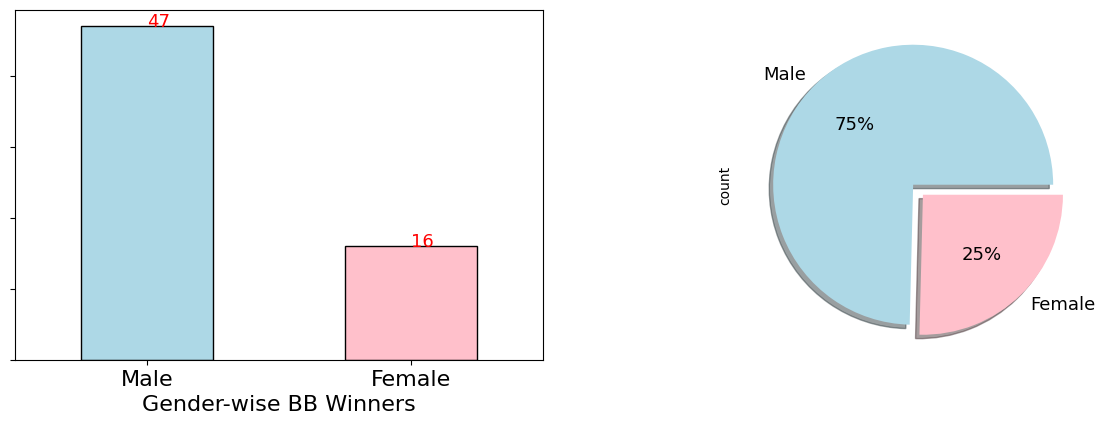

In [57]:
# Gender of Season title Winners
print(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts(), '\n')

# In percentage
print(round(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

plt.figure(figsize=(15, 10))
ax1=plt.subplot(221)
bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts().plot(kind='bar', color=["lightblue","pink"], ec="k")
plt.xlabel("Gender-wise BB Winners", fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.setp(ax1.get_yticklabels(), visible=False)

for x,y in enumerate(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts()):
    plt.annotate(y, (x,y), fontsize=13, color="Red")

ax2=plt.subplot(222)
bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts().plot(kind='pie', autopct='%.0f%%', explode = (0, 0.10), colors=["lightblue","pink"], shadow=True,fontsize=13)

Age
Middle    42
Young     20
Old        1
Name: count, dtype: int64 

Age
Middle    67%
Young     32%
Old        2%
Name: proportion, dtype: object


<Axes: ylabel='count'>

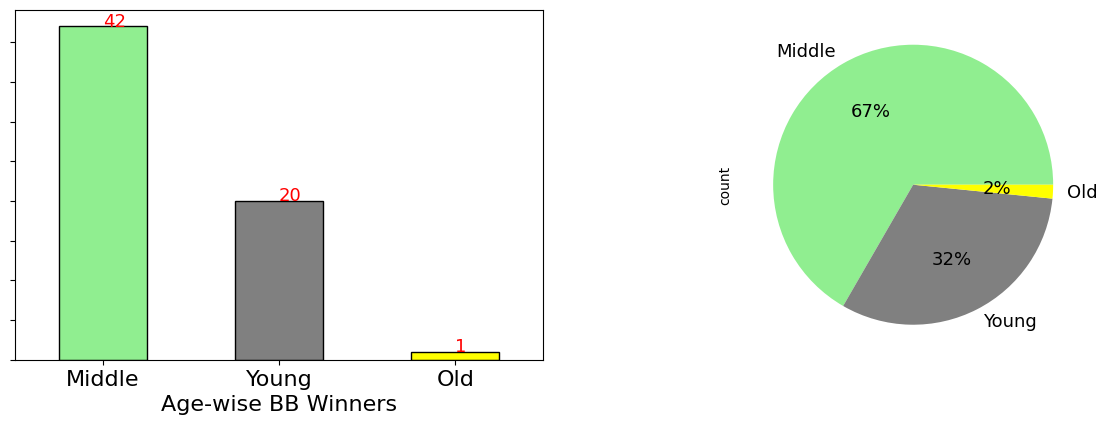

In [58]:
# Age of Season title Winners   (Age <30 young, 30-50 middle, >50 old)
print(bigg_boss.loc[bigg_boss.Winner==1, 'Age'].value_counts(), '\n')

# In percentage
print(round(bigg_boss.loc[bigg_boss.Winner==1, 'Age'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

plt.figure(figsize=(15, 10))
ax1=plt.subplot(221)
bigg_boss.loc[bigg_boss.Winner==1, 'Age'].value_counts().plot(kind='bar', color=["lightgreen", "gray", "yellow"], ec="k")
plt.xlabel("Age-wise BB Winners", fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.setp(ax1.get_yticklabels(), visible=False)

for x,y in enumerate(bigg_boss.loc[bigg_boss.Winner==1, 'Age'].value_counts()):
    plt.annotate(y, (x,y), fontsize=13, color="Red")

ax2=plt.subplot(222)
bigg_boss.loc[bigg_boss.Winner==1, 'Age'].value_counts().plot(kind='pie', autopct='%.0f%%', explode = (0, 0, 0), colors=["lightgreen", "gray", "yellow"], fontsize=13)

## ➡️ No wild card entry housemate won the Bigg Boss competition, until August 2023,
### but 2 wild-card winners after that.

In [59]:
# Entry type (wildcard or not) of the Season Winners
bigg_boss.loc[bigg_boss.Winner==1, 'Wild Card'].value_counts()

Wild Card
No     60
Yes     3
Name: count, dtype: int64

In [60]:
bigg_boss.loc[bigg_boss.Winner==1, 'Season Length'].value_counts().sort_index()

# Length of the season (in days) - Number of Winners

Season Length
28      1
42      3
57      1
70      3
84      2
86      1
90      1
95      1
97      2
98     15
99      1
102     1
103     1
105    17
106     3
107     1
112     3
117     1
119     1
120     1
134     1
140     1
141     1
Name: count, dtype: int64

In [61]:
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Housemates'].value_counts().sort_index()

# Number of Housemates in house - Number of Winners

Number of Housemates
10     1
13     1
15     7
16     5
17     8
18    11
19     7
20    10
21     6
22     2
23     2
24     2
25     1
Name: count, dtype: int64

In [62]:
# Number of eliminations or evictions faced by the Bigg Boss competition winners
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Evictions Faced'].value_counts().sort_index()

# Number of eliminations faced - Number of Winners

Number of Evictions Faced
1      1
2      3
4      7
5      7
6      7
7      9
8      6
9     11
10     3
11     2
12     5
13     1
14     1
Name: count, dtype: Int64

In [63]:
# 4 re-entered contestant won Bigg Boss title
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Re-entries'].value_counts()

Number of Re-entries
0    49
1     4
Name: count, dtype: Int64

In [64]:
# Bigg Boss title winners number of times elected as captain
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Times Elected as Captain'].value_counts().sort_index()

# Number of times elected as Captain - Number of winners

Number of Times Elected as Captain
0    13
1    23
2    17
3     3
4     2
Name: count, dtype: Int64

In [65]:
bigg_boss.loc[bigg_boss.Winner==1, 'Contestant Number'].value_counts().sort_index()

# Contestant Number in the season - Number of winners

Contestant Number
1.0     3
2.0     8
3.0     5
4.0     7
5.0     2
6.0     1
7.0     5
9.0     1
10.0    6
11.0    1
12.0    3
13.0    2
14.0    3
16.0    3
17.0    4
18.0    1
19.0    1
21.0    2
Name: count, dtype: int64

In [66]:
# Winners who Won Ticket to Finale
bigg_boss.loc[bigg_boss.Winner==1, 'Won Ticket to Finale'].value_counts()

# Won Ticket to Finale - Number of winners

Won Ticket to Finale
1.0    6
Name: count, dtype: int64

In [67]:
# Winners who Won Eviction Free Pass
bigg_boss.loc[bigg_boss.Winner==1, 'Won Eviction Free Pass'].value_counts()

# Won Eviction Free Pass - Number of winners

Won Eviction Free Pass
1.0    3
2.0    1
Name: count, dtype: int64

In [68]:
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Times Best Performer'].value_counts()

# Number of Times Best Performer - Number of winners

Number of Times Best Performer
1.0    1
5.0    1
Name: count, dtype: int64

In [69]:
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Times Worst Performer'].value_counts()

# Number of Times Worst Performer - Number of winners

Number of Times Worst Performer
1.0    4
2.0    1
Name: count, dtype: int64

## 🔵 BB Telugu Seasons

In [70]:
lang='Telugu'

# All Bigg Boss Telugu Participants
bigg_boss.loc[(bigg_boss['Language']==lang)]

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
618,Telugu,1,Aadarsh Balakrishna,Actor,Male,Middle,2017-07-16,2017-09-24,10,12.0,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0,Star Maa,NaN,15.0,"Telangana, Andhra Pradesh",Lonavala,No,NaN,NaN,4,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7,1,0,10,40
619,Telugu,1,Archana,Actress,Female,Middle,2017-07-16,2017-09-24,10,1.0,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0,Star Maa,NaN,15.0,"Telangana, Andhra Pradesh",Lonavala,No,NaN,NaN,6,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5,1,0,10,60
620,Telugu,1,Dhanraj,Comedian,Male,Middle,2017-07-16,2017-08-26,6,14.0,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0,Star Maa,NaN,15.0,"Telangana, Andhra Pradesh",Lonavala,No,NaN,NaN,3,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,10,30
621,Telugu,1,Hari Teja,Actress,Female,Young,2017-07-16,2017-09-24,10,13.0,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0,Star Maa,NaN,15.0,"Telangana, Andhra Pradesh",Lonavala,No,NaN,NaN,6,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5,1,0,10,60
622,Telugu,1,Jyothi,Actress,Female,Middle,2017-07-16,2017-07-23,1,6.0,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0,Star Maa,NaN,15.0,"Telangana, Andhra Pradesh",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,Telugu,8,Mehaboob Shaikh,Social Media Star,Male,Young,NaT,2024-10-27,8,18.0,Yes,103,22,2024-09-01,2025-01-05,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,15.9,"Telangana, Andhra Pradesh",Hyderabad,No,LimitlessEntertainment,NaN,2,1,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,15,13
783,Telugu,8,Rohini Reddy,Soap Actress,Female,Young,NaT,2024-12-08,14,19.0,Yes,103,22,2024-09-01,2025-01-05,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,15.9,"Telangana, Andhra Pradesh",Hyderabad,No,LimitlessEntertainment,NaN,1,1,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,15,7
784,Telugu,8,Gautham Krishna,Actor,Male,Young,NaT,NaT,<NA>,20.0,Yes,103,22,2024-09-01,2025-01-05,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,15.9,"Telangana, Andhra Pradesh",Hyderabad,No,LimitlessEntertainment,NaN,7,1,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1,0,15,47
785,Telugu,8,Avinash,Comedian,Male,Middle,NaT,NaT,<NA>,21.0,Yes,103,22,2024-09-01,2025-01-05,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,15.9,"Telangana, Andhra Pradesh",Hyderabad,No,LimitlessEntertainment,NaN,2,2,<NA>,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,6,1,0,15,13


In [71]:
# BiggBoss Telugu Winners
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner']==1), :]

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
631,Telugu,1,Siva Balaji,Actor,Male,Middle,2017-07-16,NaT,<NA>,7.0,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,5000000,Star Maa,NaN,15.0,"Telangana, Andhra Pradesh",Lonavala,No,NaN,NaN,4,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,8,1,1,10,40
641,Telugu,2,Kaushal Manda,Actor,Male,Middle,2018-06-10,NaT,<NA>,11.0,No,112,18,2018-06-10,2018-09-30,Nani,NaN,5000000,Star Maa,NaN,15.0,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,11,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,10,1,1,16,69
660,Telugu,3,Rahul Sipligunj,Singer,Male,Young,2019-07-21,NaT,<NA>,6.0,No,105,17,2019-07-21,2019-11-03,Nagarjuna,Ramya Krishnan,5000000,Star Maa,Disney+ Hotstar,18.1,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,12,0,0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,9,1,1,15,80
669,Telugu,4,Abijeet Duddala,Actor,Male,Middle,2020-09-06,NaT,<NA>,4.0,No,105,19,2020-09-06,2020-12-20,Nagarjuna,Samantha,2500000,Star Maa,Disney+ Hotstar,20.1,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,12,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1,15,80
703,Telugu,5,Sunny,Video Jockey,Male,Middle,2021-09-05,NaT,<NA>,2.0,No,105,19,2021-09-05,2021-12-19,Nagarjuna,NaN,5000000,Star Maa,Disney+ Hotstar,18.2,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,9,1,0,0.0,0.0,NaN,NaN,1.0,NaN,2.0,NaN,10,1,1,15,60
712,Telugu,Non-Stop,Bindu Madhavi,Actress,Female,Middle,2022-02-26,NaT,<NA>,17.0,No,84,18,2022-02-26,2022-05-21,Nagarjuna,NaN,4000000,NaN,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",Hyderabad,Yes,NaN,NaN,9,0,0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,10,1,1,12,75
738,Telugu,6,Revanth,Singer,Male,Middle,2022-09-04,NaT,<NA>,21.0,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,1000000,Star Maa,Disney+ Hotstar,8.4,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,12,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1,15,80
750,Telugu,7,Pallavi Prashanth,Social Media Star,Male,Young,2023-09-03,NaT,<NA>,13.0,No,105,19,2023-09-03,2023-12-17,Nagarjuna,NaN,3500000,Star Maa,Disney+ Hotstar,19.9,"Telangana, Andhra Pradesh",Hyderabad,No,UltaPulta,NaN,7,1,<NA>,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,9,1,1,15,47
772,Telugu,8,Nikhil Maliyakkal,Soap Actor,Male,Middle,2024-09-01,NaT,<NA>,2.0,No,103,22,2024-09-01,2025-01-05,Nagarjuna,NaN,5500000,Star Maa,Disney+ Hotstar,15.9,"Telangana, Andhra Pradesh",Hyderabad,No,LimitlessEntertainment,NaN,9,3,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1,15,60


In [72]:
# Telugu Bigg Boss all seasons finalists
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Finalist']==1), :]

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
618,Telugu,1,Aadarsh Balakrishna,Actor,Male,Middle,2017-07-16,2017-09-24,10,12.0,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0,Star Maa,NaN,15.0,"Telangana, Andhra Pradesh",Lonavala,No,NaN,NaN,4,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7,1,0,10,40
619,Telugu,1,Archana,Actress,Female,Middle,2017-07-16,2017-09-24,10,1.0,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0,Star Maa,NaN,15.0,"Telangana, Andhra Pradesh",Lonavala,No,NaN,NaN,6,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5,1,0,10,60
621,Telugu,1,Hari Teja,Actress,Female,Young,2017-07-16,2017-09-24,10,13.0,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0,Star Maa,NaN,15.0,"Telangana, Andhra Pradesh",Lonavala,No,NaN,NaN,6,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5,1,0,10,60
631,Telugu,1,Siva Balaji,Actor,Male,Middle,2017-07-16,NaT,<NA>,7.0,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,5000000,Star Maa,NaN,15.0,"Telangana, Andhra Pradesh",Lonavala,No,NaN,NaN,4,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,8,1,1,10,40
633,Telugu,1,Navdeep,Actor,Male,Middle,2017-08-14,2017-09-24,10,16.0,Yes,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0,Star Maa,NaN,15.0,"Telangana, Andhra Pradesh",Lonavala,No,NaN,NaN,3,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,9,1,0,10,30
637,Telugu,2,Deepti Nallamuthu,News Presenter,Female,Middle,2018-06-10,2018-09-30,16,3.0,No,112,18,2018-06-10,2018-09-30,Nani,NaN,0,Star Maa,NaN,15.0,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,9,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5,1,0,16,56
640,Telugu,2,Geetha Madhuri,Singer,Female,Young,2018-06-10,2018-09-30,16,1.0,No,112,18,2018-06-10,2018-09-30,Nani,NaN,0,Star Maa,NaN,15.0,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,7,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Success,8,1,0,16,44
641,Telugu,2,Kaushal Manda,Actor,Male,Middle,2018-06-10,NaT,<NA>,11.0,No,112,18,2018-06-10,2018-09-30,Nani,NaN,5000000,Star Maa,NaN,15.0,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,11,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,10,1,1,16,69
645,Telugu,2,Samrat Reddy,Actor,Male,Middle,2018-06-10,2018-09-30,16,13.0,No,112,18,2018-06-10,2018-09-30,Nani,NaN,0,Star Maa,NaN,15.0,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,3,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5,1,0,16,19
648,Telugu,2,Tanish Alladi,Actor,Male,Young,2018-06-10,2018-09-30,16,4.0,No,112,18,2018-06-10,2018-09-30,Nani,NaN,0,Star Maa,NaN,15.0,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,5,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7,1,0,16,31


In [73]:
# Number of finalists gender wise, in each BB Telugu season
bigg_boss[(bigg_boss['Language']==lang) & (bigg_boss['Finalist']==1)].groupby('Gender')['Season Number'].value_counts().sort_index()

Gender  Season Number
Female  1                2
        2                2
        3                1
        4                2
        5                1
        6                2
        7                1
        8                1
        Non-Stop         3
Male    1                3
        2                3
        3                4
        4                3
        5                4
        6                4
        7                5
        8                4
        Non-Stop         4
Name: count, dtype: int64

In [74]:
# Number of finalists age wise, in each Telugu BiggBoss season
bigg_boss[(bigg_boss['Language']==lang) & (bigg_boss['Finalist']==1)].groupby('Age')['Season Number'].value_counts().sort_index()

Age     Season Number
Middle  1                4
        2                3
        3                3
        4                1
        5                3
        6                4
        7                2
        8                2
        Non-Stop         2
Old     7                1
Young   1                1
        2                2
        3                2
        4                4
        5                2
        6                2
        7                3
        8                3
        Non-Stop         5
Name: count, dtype: int64

## 🔺 Bigg Boss India data set visualizations/infographics at Tableau Public -
## http://public.tableau.com/app/profile/satya.thirumani/viz/BiggBossIndia_16434338263440/BBStory

In [75]:
IFrame('https://public.tableau.com/views/BiggBossIndia_16434338263440/BBStory?:language=en-GB&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link', width=1000, height=1000)

In [76]:
# Bigg Boss Telugu current season participants
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Season Number']=='8'), :]

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
765,Telugu,8,Abhay Bethiganti,Actor,Male,Middle,2024-09-01,2024-09-22,3,3.0,No,103,22,2024-09-01,2025-01-05,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,15.9,"Telangana, Andhra Pradesh",Hyderabad,No,LimitlessEntertainment,NaN,1,1,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,15,7
766,Telugu,8,Aditya Om,Actor,Male,Middle,2024-09-01,2024-10-03,5,7.0,No,103,22,2024-09-01,2025-01-05,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,15.9,"Telangana, Andhra Pradesh",Hyderabad,No,LimitlessEntertainment,NaN,3,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,15,20
767,Telugu,8,Bezawada Bebakka/Madhoo Nekkanti,Social Media Star,Female,Old,2024-09-01,2024-09-08,1,5.0,No,103,22,2024-09-01,2025-01-05,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,15.9,"Telangana, Andhra Pradesh",Hyderabad,No,LimitlessEntertainment,NaN,1,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,15,7
768,Telugu,8,Kirrak Seetha,Actress,Female,Young,2024-09-01,2024-10-13,6,9.0,No,103,22,2024-09-01,2025-01-05,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,15.9,"Telangana, Andhra Pradesh",Hyderabad,No,LimitlessEntertainment,NaN,3,1,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,15,20
769,Telugu,8,Nabeel Afridi,Social Media Star,Male,Young,2024-09-01,NaT,<NA>,14.0,No,103,22,2024-09-01,2025-01-05,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,15.9,"Telangana, Andhra Pradesh",Hyderabad,No,LimitlessEntertainment,NaN,7,1,<NA>,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,6,1,0,15,47
770,Telugu,8,Naga Manikanta,Soap Actor,Male,Young,2024-09-01,2024-10-20,7,10.0,No,103,22,2024-09-01,2025-01-05,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,15.9,"Telangana, Andhra Pradesh",Hyderabad,No,LimitlessEntertainment,NaN,6,<NA>,<NA>,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,15,40
771,Telugu,8,Nainika Anasuru,Choreographer,Female,Young,2024-09-01,2024-10-06,5,13.0,No,103,22,2024-09-01,2025-01-05,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,15.9,"Telangana, Andhra Pradesh",Hyderabad,No,LimitlessEntertainment,NaN,3,1,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,15,20
772,Telugu,8,Nikhil Maliyakkal,Soap Actor,Male,Middle,2024-09-01,NaT,<NA>,2.0,No,103,22,2024-09-01,2025-01-05,Nagarjuna,NaN,5500000,Star Maa,Disney+ Hotstar,15.9,"Telangana, Andhra Pradesh",Hyderabad,No,LimitlessEntertainment,NaN,9,3,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1,15,60
773,Telugu,8,Prerana Kambam,Actress,Female,Young,2024-09-01,NaT,<NA>,4.0,No,103,22,2024-09-01,2025-01-05,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,15.9,"Telangana, Andhra Pradesh",Hyderabad,No,LimitlessEntertainment,NaN,10,1,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,1,0,15,67
774,Telugu,8,Prithviraj Shetty,Actor,Male,Young,2024-09-01,2024-12-01,13,11.0,No,103,22,2024-09-01,2025-01-05,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,15.9,"Telangana, Andhra Pradesh",Hyderabad,No,LimitlessEntertainment,NaN,11,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,15,73


In [77]:
# Bigg Boss Telugu Housemate's Gender
print(bigg_boss.loc[(bigg_boss['Language']==lang), 'Gender'].value_counts(), "\n")

Gender
Female         87
Male           80
Transgender     2
Name: count, dtype: int64 



In [78]:
# Telugu BiggBoss Housemate's Age
print(bigg_boss.loc[(bigg_boss['Language']==lang), 'Age'].value_counts(), "\n")

Age
Middle    81
Young     81
Old        7
Name: count, dtype: int64 



In [79]:
print("\nTop 6 Telugu contestants who faced maximum number of evictions\n")
tmax=bigg_boss.loc[(bigg_boss['Language']==lang), 'Number of Evictions Faced'].max()
print(bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Number of Evictions Faced']>=tmax-1)][["Season Number","Name","Number of Evictions Faced"]].head(15).sort_values("Number of Evictions Faced",ascending=False).to_string(index=False))


Top 6 Telugu contestants who faced maximum number of evictions

Season Number            Name  Number of Evictions Faced
            7    Prince Yawar                         13
            3 Rahul Sipligunj                         12
            4 Abijeet Duddala                         12
            4    Monal Gajjar                         12
            6       Adi Reddy                         12
            6         Revanth                         12


In [80]:
print("\nTop 4 Telugu contestants who faced maximum percentage of evictions (they were in nominations almost every week)\n")
tpmax=bigg_boss.loc[(bigg_boss['Language']==lang), 'Evictions Faced Percentage'].max()
print(bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Evictions Faced Percentage']>=tpmax-10)][["Season Number","Name","Number of Evictions Faced","Season Length in weeks","Evictions Faced Percentage"]].head(15).sort_values("Evictions Faced Percentage",ascending=False).to_string(index=False))


Top 4 Telugu contestants who faced maximum percentage of evictions (they were in nominations almost every week)

Season Number           Name  Number of Evictions Faced  Season Length in weeks  Evictions Faced Percentage
     Non-Stop Mitraaw Sharma                         11                      12                          92
            7   Prince Yawar                         13                      15                          87
     Non-Stop  Ariyana Glory                         10                      12                          83
     Non-Stop          Shiva                         10                      12                          83


## 🔍 Preparing Data for ML modelling

In [81]:
# Handling NULL values
bigg_boss.isnull().sum()

Language                                 0
Season Number                            0
Name                                     0
Profession                               0
Gender                                   0
Age                                      0
Entry Date                             172
Elimination Date                       982
Elimination Week Number                142
Contestant Number                       79
Wild Card                                0
Season Length                            0
Number of Housemates                     0
Season Start Date                        0
Season End Date                          0
Host Name                                0
Guest Host Name                       1062
Prize Money (INR)                        0
Broadcasted By                          95
OTT Platform                           412
Average TRP                            526
Most Viewed States                       0
House Location                           0
OTT Season 

In [82]:
# Removing records where Name field is empty
bigg_boss = bigg_boss.loc[bigg_boss.Name.notnull()]
bigg_boss.reset_index(drop=True,inplace=True)

In [83]:
# Contestant might have faced at least one eviction, so filling NaN with 'Number of Evictions Faced' with 1
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].fillna(1)

# Number of re-entries are very less, so filling NULLs in 'Number of re-entries' with 0
bigg_boss['Number of Re-entries'] = bigg_boss['Number of Re-entries'].fillna(0)

# Filling blank values in 'Average TRP' column with average
bigg_boss['Average TRP'] = bigg_boss['Average TRP'].fillna(bigg_boss['Average TRP'].mean())

# Filling NULLs in 'Number of times elected as Captain' with 0
bigg_boss['Number of Times Elected as Captain'] = bigg_boss['Number of Times Elected as Captain'].fillna(0)

In [84]:
bigg_boss['Season Starting Year'] = bigg_boss['Season Start Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Ending Year'] = bigg_boss['Season End Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Starting Quarter'] = bigg_boss['Season Start Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss['Season Ending Quarter'] = bigg_boss['Season End Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 46 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Language                            1205 non-null   object        
 1   Season Number                       1205 non-null   object        
 2   Name                                1205 non-null   object        
 3   Profession                          1205 non-null   object        
 4   Gender                              1205 non-null   object        
 5   Age                                 1205 non-null   object        
 6   Entry Date                          1033 non-null   datetime64[ns]
 7   Elimination Date                    223 non-null    datetime64[ns]
 8   Elimination Week Number             1063 non-null   Int32         
 9   Contestant Number                   1126 non-null   float64       
 10  Wild Card               

In [85]:
bigg_boss.head()

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
0,Hindi,1,Amit Sadh,Soap Actor,Male,Young,2006-11-03,NaT,10,5.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,12,17,2006,2007,4,1
1,Hindi,1,Anupama Verma,Model,Female,Young,2006-11-03,NaT,5,8.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,12,8,2006,2007,4,1
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,Middle,2006-11-03,NaT,4,9.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,12,8,2006,2007,4,1
3,Hindi,1,Bobby Darling,Activist,Transgender,Young,2006-11-03,NaT,1,12.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,12,8,2006,2007,4,1
4,Hindi,1,Carol Gracias,Model,Female,Young,2006-11-03,2007-01-26,12,2.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,12,42,2006,2007,4,1


In [86]:
bigg_boss.tail()

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
1200,Malayalam,6,Sibin Benjamin,Disc Jockey,Male,Middle,NaT,NaT,7,21.0,Yes,98,25,2024-03-10,2024-06-16,Mohanlal,NaN,0,Asianet,Disney+ Hotstar,9.489072,Kerala,Chennai,No,Let'sChangeThingsUp!,NaN,1,0,1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,7,2024,2024,1,2
1201,Malayalam,6,Nandana C,Commoner,Female,Young,NaT,NaT,12,22.0,Yes,98,25,2024-03-10,2024-06-16,Mohanlal,NaN,0,Asianet,Disney+ Hotstar,9.489072,Kerala,Chennai,No,Let'sChangeThingsUp!,NaN,3,1,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,21,2024,2024,1,2
1202,Malayalam,6,Abhishek Sreekumar,Actor,Male,Young,NaT,NaT,14,23.0,Yes,98,25,2024-03-10,2024-06-16,Mohanlal,NaN,0,Asianet,Disney+ Hotstar,9.489072,Kerala,Chennai,No,Let'sChangeThingsUp!,NaN,9,1,0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,6,1,0,14,64,2024,2024,1,2
1203,Malayalam,6,Pooja Krishna,Social Media Star,Female,Young,NaT,NaT,7,24.0,Yes,98,25,2024-03-10,2024-06-16,Mohanlal,NaN,0,Asianet,Disney+ Hotstar,9.489072,Kerala,Chennai,No,Let'sChangeThingsUp!,NaN,0,0,1,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,0,2024,2024,1,2
1204,Malayalam,6,Sai Krishnan,Social Media Star,Male,Middle,NaT,NaT,13,25.0,Yes,98,25,2024-03-10,2024-06-16,Mohanlal,NaN,0,Asianet,Disney+ Hotstar,9.489072,Kerala,Chennai,No,Let'sChangeThingsUp!,NaN,3,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,21,2024,2024,1,2


In [87]:
# Updating last week-end elimination/entries manually
# bigg_boss.iloc[770, 38] = 0

In [88]:
train = bigg_boss.loc[(bigg_boss['Winner'].notnull()), :]
train.sample(10)

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,Middle,2006-11-03,NaT,4,9.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0,Sony,NaN,2.720000,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,12,8,2006,2007,4,1
73,Hindi,5,Sonika Kaliraman,Wrestler,Female,Young,2011-10-02,NaT,<NA>,10.0,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0,Colors,NaN,4.190000,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,NaN,NaN,0,0,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,0,2011,2012,4,1
86,Hindi,6,Niketan Madhok,Model,Male,Middle,2012-10-07,2013-01-12,14,13.0,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0,Colors,NaN,3.810000,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,14,36,2012,2013,4,1
532,Kannada,8,Prashanth Sambargi,Activist,Male,Middle,2021-02-28,NaT,<NA>,16.0,No,117,20,2021-02-28,2021-08-08,Sudeep,NaN,0,Colors Kannada,Voot,9.489072,Karnataka,Bengaluru,No,NaN,NaN,14,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7,1,0,17,82,2021,2021,1,3
627,Telugu,1,Mumaith Khan,Actress,Female,Middle,2017-07-16,2017-09-03,7,3.0,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0,Star Maa,NaN,15.000000,"Telangana, Andhra Pradesh",Lonavala,No,NaN,NaN,3,1,2,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,10,30,2017,2017,3,3
437,Kannada,3,Pooja Gandhi,Actress,Female,Middle,2015-10-25,NaT,14,NaN,No,98,18,2015-10-25,2016-01-31,Sudeep,NaN,0,Colors Kannada,NaN,9.489072,Karnataka,Bengaluru,No,There is no place for drama here,NaN,6,1,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,14,43,2015,2016,4,1
632,Telugu,1,Diksha Panth,Actress,Female,Young,2017-07-31,2017-09-17,9,15.0,Yes,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0,Star Maa,NaN,15.000000,"Telangana, Andhra Pradesh",Lonavala,No,NaN,NaN,3,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,10,30,2017,2017,3,3
744,Telugu,6,Sudeepa Pinky,Actress,Female,Middle,2022-09-04,2022-10-16,6,2.0,No,105,21,2022-09-04,2022-12-18,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,8.400000,"Telangana, Andhra Pradesh",Hyderabad,No,NaN,NaN,3,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,15,20,2022,2022,3,4
70,Hindi,5,Shakti Kapoor,Actor,Male,Old,2011-10-02,NaT,4,1.0,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0,Colors,NaN,4.190000,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,NaN,NaN,1,2,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,7,2011,2012,4,1
979,Marathi,1,Nandkishor Chaughule,Comedian,Male,Middle,NaT,NaT,12,18.0,Yes,98,18,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0,Colors Marathi,NaN,9.489072,Maharashtra,Lonavala,No,NaN,Traditional,2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,14,14,2018,2018,2,3


In [89]:
test = bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner'].isnull()), :]
test

# Participants who are still in current Bigg Boss Telugu season

,Language,Season Number,Name,Profession,Gender,Age,Entry Date,Elimination Date,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter


In [90]:
BB_telugu_participant = test[['Name']]
BB_telugu_participant.reset_index(drop=True, inplace=True)
BB_telugu_participant

,Name


In [91]:
train.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date"], axis=1, inplace=True)
test.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date","Winner"], axis=1, inplace=True)

In [92]:
train.head()

,Language,Season Number,Profession,Gender,Age,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
0,Hindi,1,Soap Actor,Male,Young,10,5.0,No,86,15,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,2,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,12,17,2006,2007,4,1
1,Hindi,1,Model,Female,Young,5,8.0,No,86,15,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,12,8,2006,2007,4,1
2,Hindi,1,Pageant Winner,Male,Middle,4,9.0,No,86,15,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,12,8,2006,2007,4,1
3,Hindi,1,Activist,Transgender,Young,1,12.0,No,86,15,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,1,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,0,12,8,2006,2007,4,1
4,Hindi,1,Model,Female,Young,12,2.0,No,86,15,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,NaN,NaN,5,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1,0,12,42,2006,2007,4,1


In [93]:
test.head()

,Language,Season Number,Profession,Gender,Age,Elimination Week Number,Contestant Number,Wild Card,Season Length,Number of Housemates,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Season Slogan,Season Theme,Number of Evictions Faced,Number of Times Elected as Captain,Number of Re-entries,Walked,Ejected,In Secret-Room,Won Eviction Free Pass,Won Ticket to Finale,Number of Times Best Performer,Number of Times Worst Performer,Secret Task,Social Media Popularity,Finalist,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter


In [94]:
# Spread of target variable
print(train['Winner'].value_counts(normalize=True)*100)

Winner
0    94.771784
1     5.228216
Name: proportion, dtype: float64


In [95]:
# One Hot Encoding

target = train.pop('Winner')
data = pd.concat([train, test])
dummies = pd.get_dummies(data, columns=data.columns, drop_first=True, sparse=True)
train2 = dummies.iloc[:train.shape[0], :]
test = dummies.iloc[train.shape[0]:, :]

In [96]:
print(train2.shape)
print(test.shape)

(1205, 492)
(0, 492)


In [97]:
train2.isnull().sum().sort_values(ascending=False)

Language_Hindi                 False
Number of Evictions Faced_4    False
Number of Evictions Faced_2    False
Number of Evictions Faced_1    False
Season Theme_Traditional       False
                               ...  
Season Length_117              False
Season Length_112              False
Season Length_107              False
Season Length_106              False
Season Ending Quarter_4        False
Length: 492, dtype: Sparse[bool, False]

In [98]:
# train2.drop(["Season Number_Non-Stop"], axis=1, inplace=True)
# test.drop(["Season Number_Non-Stop"], axis=1, inplace=True)

In [99]:
train2.head()

,Language_Hindi,Language_Kannada,Language_Malayalam,Language_Marathi,Language_Tamil,Language_Telugu,Season Number_10,Season Number_11,Season Number_12,Season Number_13,Season Number_14,Season Number_15,Season Number_16,Season Number_17,Season Number_18,Season Number_2,Season Number_3,Season Number_4,Season Number_5,Season Number_6,Season Number_7,Season Number_8,Season Number_9,Season Number_Halla Bol,Season Number_Non-Stop,...,Season Starting Year_2023,Season Starting Year_2024,Season Ending Year_2008,Season Ending Year_2009,Season Ending Year_2011,Season Ending Year_2012,Season Ending Year_2013,Season Ending Year_2014,Season Ending Year_2015,Season Ending Year_2016,Season Ending Year_2017,Season Ending Year_2018,Season Ending Year_2019,Season Ending Year_2020,Season Ending Year_2021,Season Ending Year_2022,Season Ending Year_2023,Season Ending Year_2024,Season Ending Year_2025,Season Starting Quarter_2,Season Starting Quarter_3,Season Starting Quarter_4,Season Ending Quarter_2,Season Ending Quarter_3,Season Ending Quarter_4
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [100]:
target.values

array([0, 0, 0, ..., 0, 0, 0])

In [101]:
x_train, x_val, y_train, y_val = train_test_split(train2, target, test_size=0.25, random_state=2025)
print(x_train.shape, x_val.shape)

(903, 492) (302, 492)


In [102]:
x_train.isnull().sum().sort_values(ascending=False)

Language_Hindi                 False
Number of Evictions Faced_4    False
Number of Evictions Faced_2    False
Number of Evictions Faced_1    False
Season Theme_Traditional       False
                               ...  
Season Length_117              False
Season Length_112              False
Season Length_107              False
Season Length_106              False
Season Ending Quarter_4        False
Length: 492, dtype: Sparse[bool, False]

## 💎 Machine Learning Modelling

In [103]:
def plot_confusion_matrix():
    cm = confusion_matrix(y_val, y_predicted_val).T
    cm = cm.astype('float')/cm.sum(axis=0)
    ax = sns.heatmap(cm, annot=True, cmap='Blues')
    ax.set_xlabel('True Label', size=12)
    ax.set_ylabel('Predicted Label', size=12)

In [104]:
# Logistic Regression
for c in [1, 10, 100, 1000, 10000]:
    lr = LogisticRegression(random_state=2025, C=c).fit(x_train, y_train)
    print ("F1 score for C=%s: %s" % (c, f1_score(y_val, lr.predict(x_val), average='weighted')*100))

F1 score for C=1: 96.92776128492046
F1 score for C=10: 97.56827546491654
F1 score for C=100: 97.56827546491654
F1 score for C=1000: 97.9504811131366
F1 score for C=10000: 97.9504811131366


In [105]:
logi = LogisticRegression(random_state=2025, C=100).fit(x_train, y_train)
logi

LogisticRegression(C=100, random_state=2025)

In [106]:
predicted_val_logi = logi.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_logi > 0.3).astype("int").ravel()
print('F1 Score -', f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -', accuracy_score(y_val, y_predicted_val)*100)

F1 Score - 97.9504811131366
Accuracy Score - 98.01324503311258


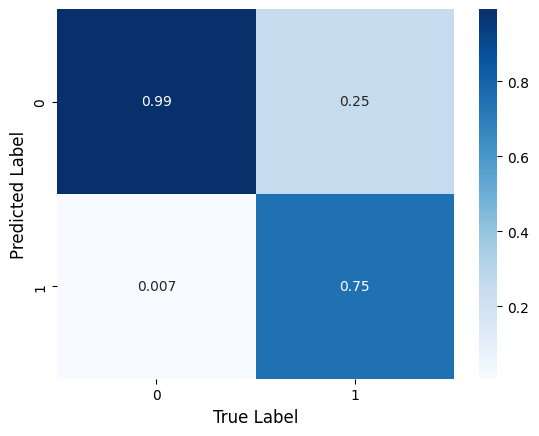

In [107]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 0.89

In [108]:
# predicted_val_logi = logi.predict_proba(test)[:, 1]
# winner_lg = pd.concat([BB_telugu_participant, pd.DataFrame(predicted_val_logi, columns=['Predicted_Winner'])], axis=1)
# winner_lg.sort_values('Predicted_Winner', ascending=False).style.hide()

## 💥 Predicted Winner for Bigg Boss Telugu Season 9, as per Logistic Regression

In [109]:
# # Predicted Winner for BiggBoss Telugu 8 Season, as per LogisticRegression
# winner_lg[winner_lg['Predicted_Winner'] == np.amax(winner_lg.Predicted_Winner)].style.hide()

In [110]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=2025).fit(x_train, y_train)
rf

RandomForestClassifier(n_estimators=200, random_state=2025)

In [111]:
predicted_val_rf = rf.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_rf > 0.3).astype("int").ravel()
print('F1 Score -', f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -', accuracy_score(y_val, y_predicted_val)*100)

# n_estimators=200 accuracy 97.82

F1 Score - 98.3191118677003
Accuracy Score - 98.34437086092716


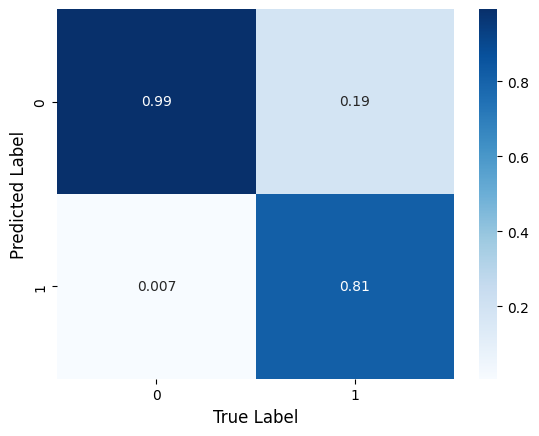

In [112]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 0.91

In [113]:
# predicted_val_rf = rf.predict_proba(test)[:, 1]
# winner_rf = pd.concat([BB_telugu_participant, pd.DataFrame(predicted_val_rf, columns=['Predicted_Winner'])], axis=1)
# winner_rf.sort_values('Predicted_Winner', ascending=False).style.hide()

## 💥 Predicted Winner for Bigg Boss Telugu Season 9, as per Random Forest

In [114]:
# # Predicted Winner for BiggBoss Telugu 8 Season, as per RandomForest
# winner_rf[winner_rf['Predicted_Winner'] == np.amax(winner_rf.Predicted_Winner)].style.hide()

## 🚀 Machine Learning (ML) models to predict Indian BiggBoss (Big Brother) season Winners

## Hindi Bigg Boss Season 19
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-hindi-season-19-winner

## Kannada Bigg Boss Season12
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-kannada-season-12-winner

## Tamil Bigg Boss Season9
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-tamil-season-9-winner

## Malayalam Bigg Boss Season7
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-malayalam-season-7-winner

## Marathi Bigg Boss Season6
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-marathi-season-6-winner

## Bangla Bigg Boss Season3
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-bangla-season-3-winner

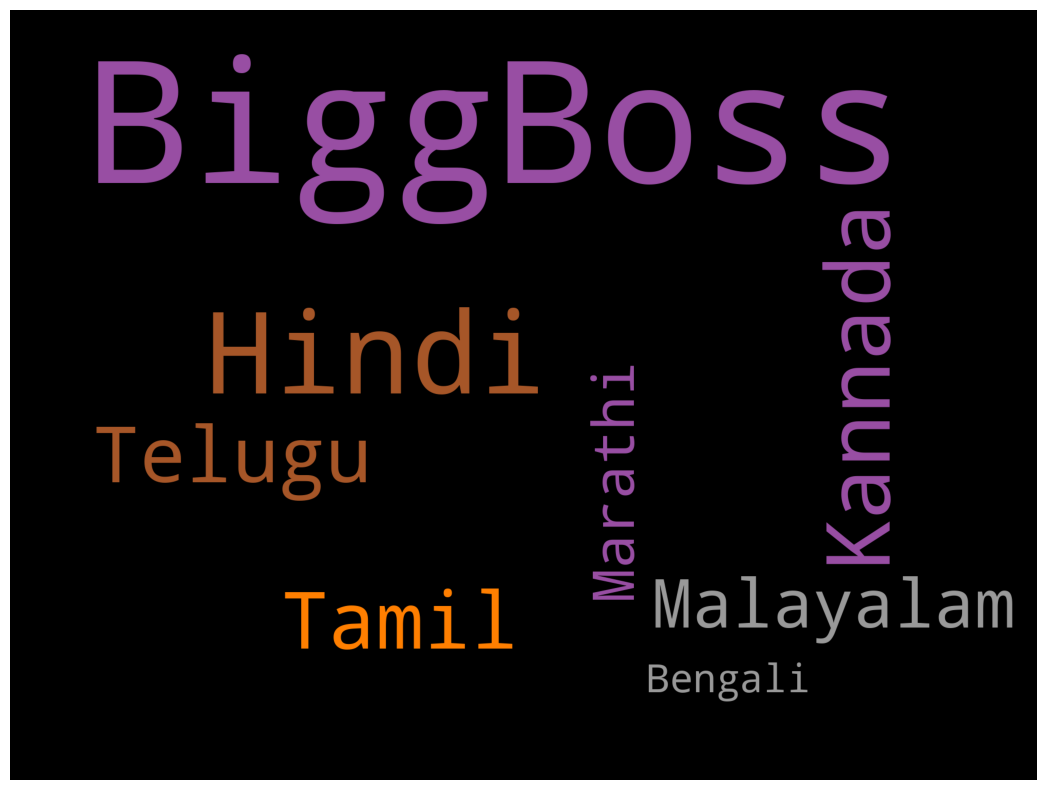

In [115]:
# Word cloud of Bigg Boss Languages
text = " BiggBoss ".join(cat for cat in bigg_boss['Language'])
wordcloud = WordCloud(width=2000, height=1500, background_color='Black', colormap='Set1', collocations=False, random_state=2025).generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

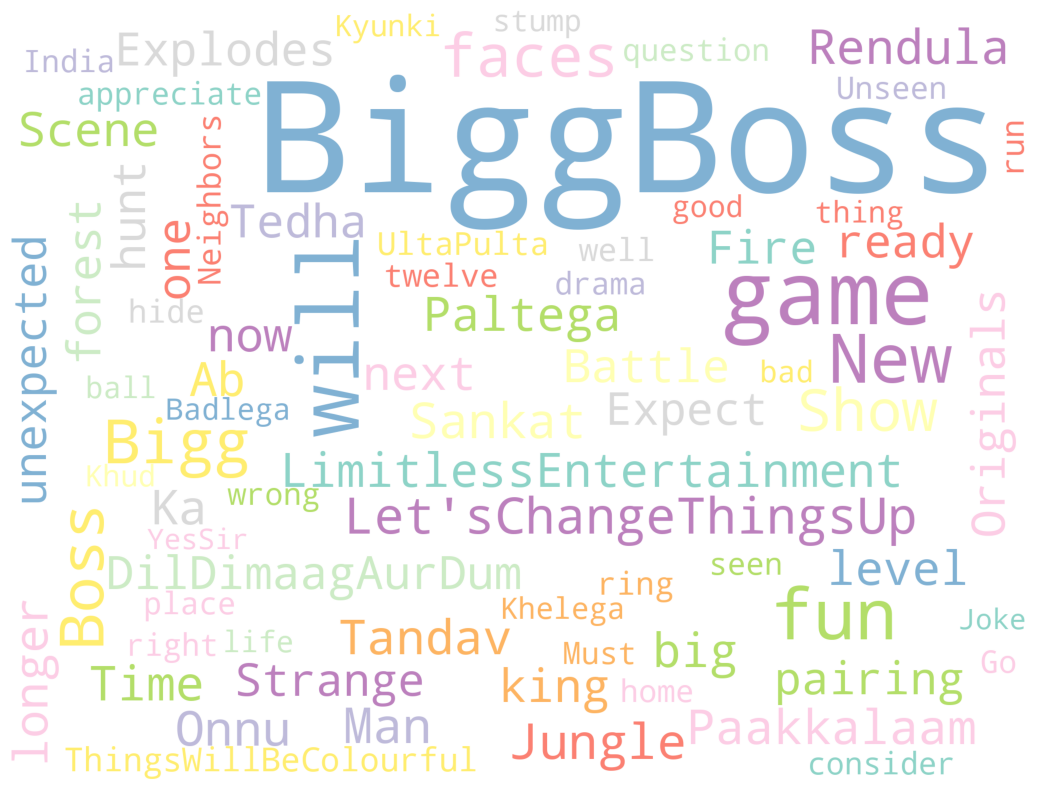

In [116]:
# Word cloud of Bigg Boss Season Slogans
text = " BiggBoss ".join(str(cat) for cat in bigg_boss[bigg_boss['Season Slogan'].notnull()]['Season Slogan'])
wordcloud = WordCloud(width=2000, height=1500, background_color='white', colormap='Set3', collocations=False, random_state=2025).generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

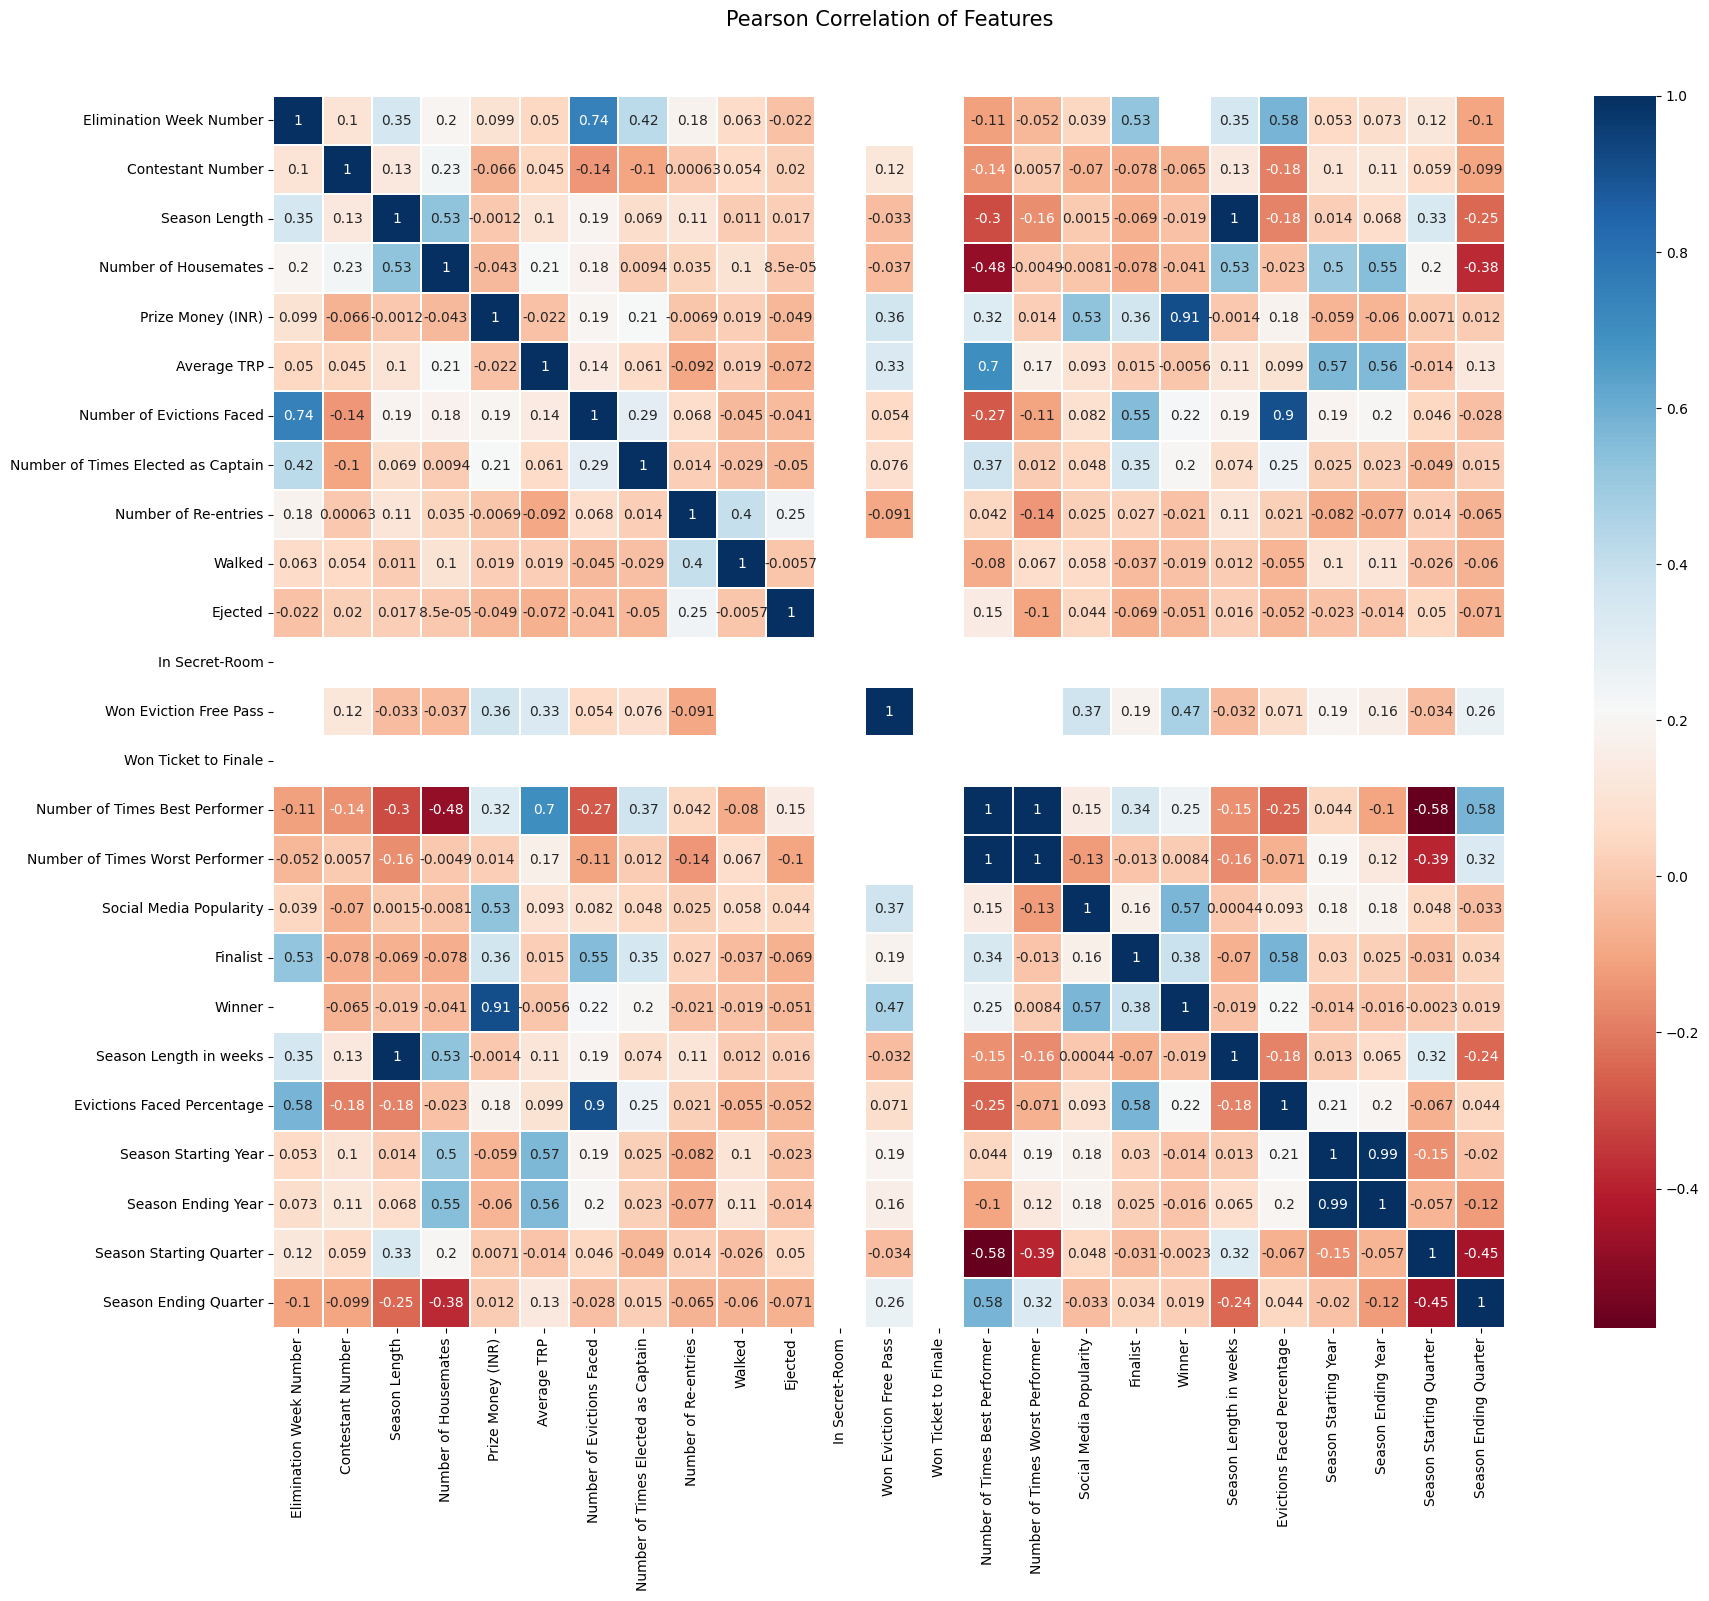

In [117]:
# Correlation matrix (Heatmap style)
corrmat = bigg_boss.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(23, 16))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(corrmat, vmax=1.0, linewidths=0.1, square=True, cmap="RdBu", linecolor='white', annot=True);

In [118]:
# Crosschecking Actor/Actress Gender
bigg_boss[bigg_boss['Profession'].str.contains('Act')].groupby('Gender')['Profession'].value_counts().unstack()
#bigg_boss.loc[(bigg_boss['Profession']=='Actress') & (bigg_boss['Gender']=='Male')]

Profession,Activist,Actor,Actor & Actress,Actress,Soap Actor,Soap Actress,Stage Actress
Gender,,,,,,,
Female,8.0,NaN,NaN,231.0,NaN,134.0,2.0
Male,6.0,152.0,NaN,NaN,81.0,NaN,NaN
Pair,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Transgender,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
print("numpy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
import matplotlib
print("matplotlib version: {}". format(matplotlib. __version__))
print("seaborn version: {}". format(sns.__version__))
import sklearn
print("sklearn version: {}". format(sklearn.__version__))
import plotly
print("plotly version: {}". format(plotly.__version__))

# Current Python package versions
# numpy version: 1.26.4
# pandas version: 2.2.3
# matplotlib version: 3.7.2
# seaborn version: 0.12.2
# sklearn version: 1.2.2
# plotly version: 5.24.1

numpy version: 1.26.4
pandas version: 2.2.3
matplotlib version: 3.7.2
seaborn version: 0.12.2
sklearn version: 1.2.2
plotly version: 5.24.1
